In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utility import p4
from utility.p5 import *
import pickle 
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

%matplotlib inline

In [2]:
f = open('camera_cals.p', 'rb')   
camera_cal = pickle.load(f) 
objpoints = camera_cal['objpoints']
imgpoints = camera_cal['imgpoints']

f = open('perspective_transformation.p', 'rb')
perspective_transformation = pickle.load(f) 

M = perspective_transformation['M']
Minv = perspective_transformation['Minv']

In [3]:
# Divide up into cars and notcars
notcar_images = glob.glob('./data/non-vehicles/**/*.png')
car_images = glob.glob('./data/vehicles/**/*.png')
cars = []
notcars = []
for image in notcar_images:
    notcars.append(image)
for image in car_images:
    cars.append(image)
    
print('car:', len(cars), 'not car:', len(notcars))

car: 8792 not car: 8968


In [4]:
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 13  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
x_start_stop = [None, None]

y_start_stop_L = [400, 656] # Min and max in y to search in slide_window()
y_start_stop_N = [400, 528] # Min and max in y to search in slide_window()



In [5]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 13 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2220


In [6]:
# Use a linear SVC 
#svc = LinearSVC()
#svc = SVC(C=10, kernel='rbf', gamma=0.001)
svc = SVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

print(round(t-t2, 2), 'Seconds to predict.')


f = open('svc_linear.p', 'wb')   
pickle.dump(svc, f)

65.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9975
15.3 Seconds to predict.


In [7]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 9)
    # Return the image
    return img

In [8]:
def detect_car(image):
    draw_image = np.copy(image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    windows_L = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_L, 
                        xy_window=(128, 128), xy_overlap=(0.7, 0.7))
    windows_N = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_N, 
                        xy_window=(64, 64), xy_overlap=(0.7, 0.7))
#    windows_S = slide_window(draw_image, x_start_stop=x_start_stop, y_start_stop=y_start_stop_S, 
#                        xy_window=(32, 32), xy_overlap=(0.7, 0.7))

    windows = np.concatenate((windows_L, windows_N), axis=0)
    hot_windows = search_windows(draw_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       
    
#    for threads in cpu_count():
        
#    async_result = pool.apply_async(search_windows, ('world', 'foo')) # tuple of args for foo

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    return draw_img, heatmap

CPU times: user 2.61 s, sys: 0 ns, total: 2.61 s
Wall time: 2.61 s
CPU times: user 2.62 s, sys: 150 ms, total: 2.77 s
Wall time: 2.64 s
CPU times: user 2.59 s, sys: 150 ms, total: 2.74 s
Wall time: 2.59 s
CPU times: user 2.62 s, sys: 120 ms, total: 2.74 s
Wall time: 2.59 s
CPU times: user 2.63 s, sys: 130 ms, total: 2.76 s
Wall time: 2.61 s
CPU times: user 2.58 s, sys: 160 ms, total: 2.74 s
Wall time: 2.59 s
CPU times: user 2.64 s, sys: 140 ms, total: 2.78 s
Wall time: 2.63 s


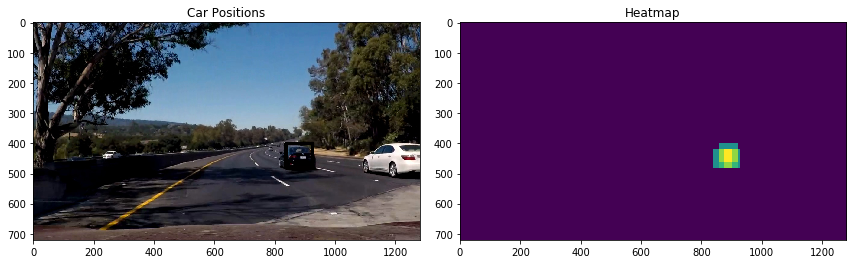

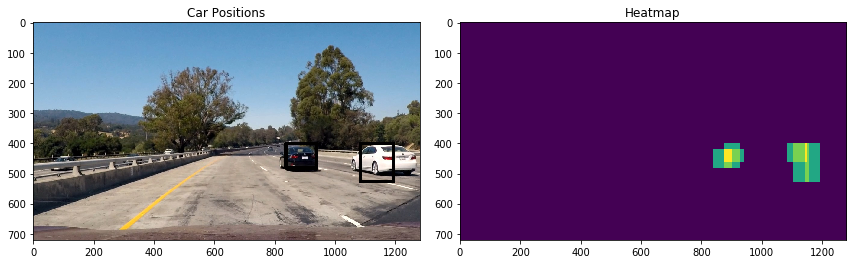

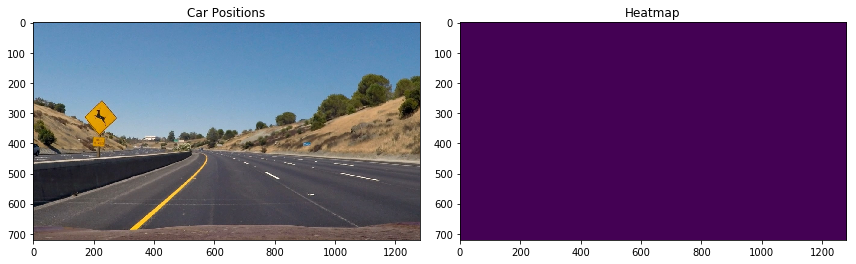

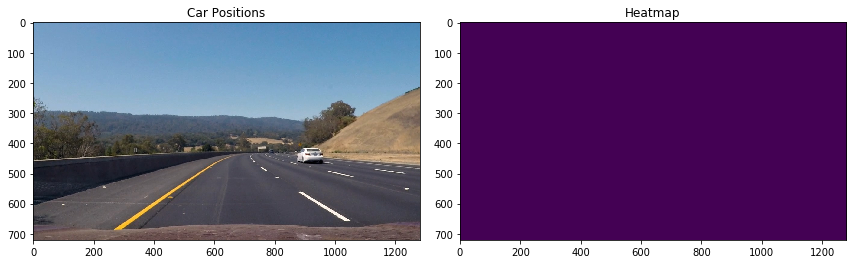

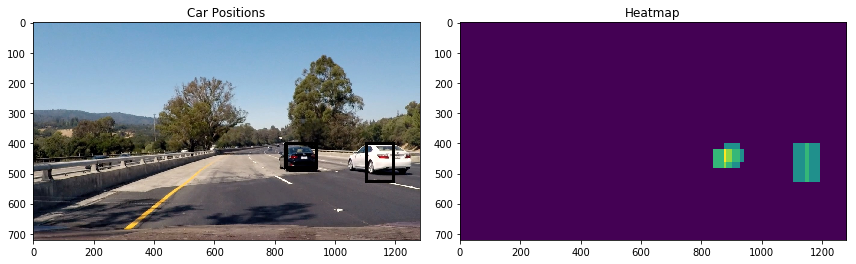

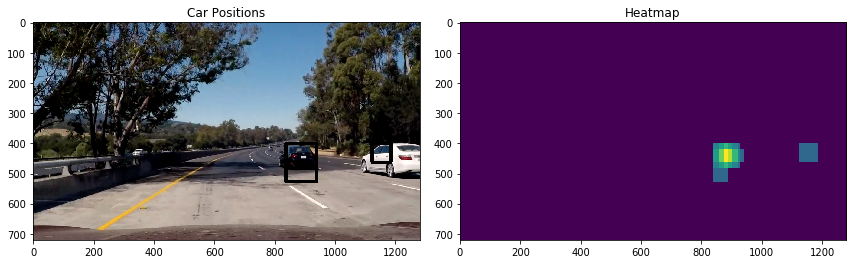

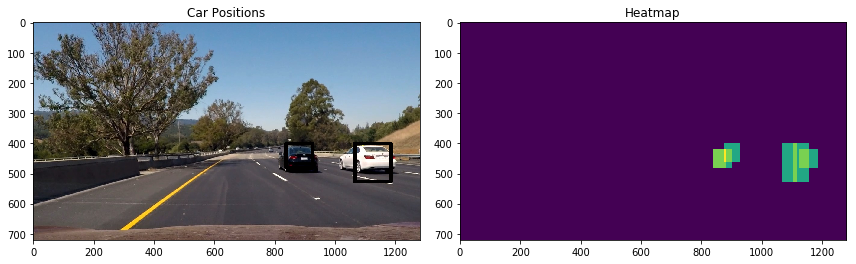

In [9]:
images = glob.glob('./test_images/*.jpg')
#images = glob.glob('./screenshots/*.jpg')


for image_name in images:
    image = plt.imread(image_name)
    %time draw_img,heatmap = detect_car(image.astype(np.float32)/255)
#    %time draw_img = find_cars(image, 400, 656, 1, svc, X_scaler, 9, 16, 2, (16, 16), 16)

    fig = plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap)
    plt.title('Heatmap')
    fig.tight_layout()

In [10]:
## sliding window + heat map
from moviepy.editor import VideoFileClip
from IPython.display import HTML

fontFace = cv2.FONT_HERSHEY_SIMPLEX
fontScale=1
thickness=2
    
def process_image(image):
    undistorted = p4.cal_undistort(image, objpoints, imgpoints)
    combined = p4.combinedThresholds(undistorted)
    
    binary_warped = p4.warper(combined, M)
#    closing = cv2.morphologyEx(binary_warped, cv2.MORPH_CLOSE, kernel)
    global left_fitx
    global right_fitx
    left_fitx, right_fitx, left_curverad, right_curverad, out_img, left_fit, right_fit = p4.fitlines(binary_warped, left_fitx, right_fitx,lf_history, rf_history)

    lf.append(left_fit)
    rf.append(right_fit)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = p4.warper(color_warp, Minv) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    
    result,heatmap = detect_car(result.astype(np.float32) /255  )
    
    result = (result*255).astype(np.uint8)
    heatmap = (heatmap*255).astype(np.uint8)
    
    middle = int((left_fitx[-1] + right_fitx[-1])//2)
    veh_pos = int(image.shape[1]//2)
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    dx = (veh_pos - middle)*xm_per_pix 
    
    #draw position lines    
    cv2.line(result, (veh_pos, 400), (veh_pos, 720), (200,200,200),2)
    cv2.line(result, (veh_pos-20, 400), (veh_pos+20, 400), (200,200,200),2)
    cv2.line(result, (veh_pos-30, 450), (veh_pos+30, 450), (200,200,200),2)
    cv2.line(result, (veh_pos-20, 500), (veh_pos+20, 500), (200,200,200),2)
    cv2.line(result, (middle, 550), (middle, 720), (200,200,200),4)

    img_out=np.zeros((576,1280,3), dtype=np.uint8)
    img_out[0:576,0:1024,:] =cv2.resize(result,(1024,576))
    #b) Threshold
    img_out[0:192,1024:1280, 0] =cv2.resize(combined,(256,192))
    img_out[0:192,1024:1280, 1] =cv2.resize(combined,(256,192))
    img_out[0:192,1024:1280, 2] =cv2.resize(combined,(256,192))
    #c)Birds eye view
    img_out[192:384,1024:1280,:] =cv2.resize(out_img,(256,192))
    img_out[384:576,1024:1280,0] =cv2.resize(heatmap,(256,192))
    img_out[384:576,1024:1280,1] =cv2.resize(heatmap,(256,192))
    img_out[384:576,1024:1280,2] =cv2.resize(heatmap,(256,192))
#    global path
#    global counter
#    cv2.imwrite('images/{}/{}.jpg'.format(path, counter), image)
#    counter += 1
    
    #Write curvature and center in image
    TextL = "Left  curv: {:>.1f} km".format(left_curverad/1000)
    TextR = "Right curv: {:>.1f} km".format(right_curverad/1000)

    cv2.putText(img_out, TextL, (130,40), fontFace, fontScale,(200,200,200), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, TextR, (130,70), fontFace, fontScale,(200,200,200), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out,'Position : %.2f m %s of center'%(abs(dx), 'left' if dx < 0 else 'right'),(50,110), 
                        fontFace, fontScale,(200,200,200),thickness,lineType = cv2.LINE_AA)

    cv2.putText(img_out, "Thresh. view", (1070,20), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Birds-eye view", (1070,212), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    cv2.putText(img_out, "Heat map", (1070,404), fontFace, .8,(200,200,0), thickness,  lineType = cv2.LINE_AA)
    
    return img_out

In [11]:
path='project'
counter = 1
lf = []
rf = []
left_fitx= [0,0,0]
right_fitx = [0,0,0]
lf_history = np.zeros((5,3))
rf_history = np.zeros((5,3))
white_output = 'project_video_processe.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)#.subclip(38,42) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

26312  -  12086
[MoviePy] >>>> Building video project_video_processe.mp4
[MoviePy] Writing video project_video_processe.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

26312  -  12086


  0%|          | 1/1261 [00:03<1:12:23,  3.45s/it]

26020  -  12078


  0%|          | 2/1261 [00:06<1:12:43,  3.47s/it]

25627  -  13375


  0%|          | 3/1261 [00:10<1:12:35,  3.46s/it]

26192  -  12649


  0%|          | 4/1261 [00:13<1:12:15,  3.45s/it]

25855  -  12645


  0%|          | 5/1261 [00:17<1:12:07,  3.45s/it]

25791  -  12358


  0%|          | 6/1261 [00:20<1:11:53,  3.44s/it]

26151  -  11319


  1%|          | 7/1261 [00:24<1:11:41,  3.43s/it]

25092  -  10574


  1%|          | 8/1261 [00:27<1:11:37,  3.43s/it]

25210  -  10585


  1%|          | 9/1261 [00:30<1:11:28,  3.43s/it]

25898  -  10045


  1%|          | 10/1261 [00:34<1:11:22,  3.42s/it]

24971  -  10119


  1%|          | 11/1261 [00:37<1:11:20,  3.42s/it]

26079  -  10912


  1%|          | 12/1261 [00:41<1:11:15,  3.42s/it]

26522  -  11567


  1%|          | 13/1261 [00:44<1:11:02,  3.42s/it]

26362  -  12198


  1%|          | 14/1261 [00:48<1:11:17,  3.43s/it]

26017  -  11434


  1%|          | 15/1261 [00:51<1:11:03,  3.42s/it]

25220  -  11546


  1%|▏         | 16/1261 [00:54<1:10:56,  3.42s/it]

25713  -  12051


  1%|▏         | 17/1261 [00:58<1:10:47,  3.41s/it]

26341  -  11413


  1%|▏         | 18/1261 [01:01<1:11:06,  3.43s/it]

26789  -  10395


  2%|▏         | 19/1261 [01:05<1:11:18,  3.45s/it]

27159  -  9300


  2%|▏         | 20/1261 [01:08<1:11:30,  3.46s/it]

28241  -  9407


  2%|▏         | 21/1261 [01:12<1:11:09,  3.44s/it]

28935  -  10013


  2%|▏         | 22/1261 [01:15<1:10:46,  3.43s/it]

28782  -  9835


  2%|▏         | 23/1261 [01:18<1:10:57,  3.44s/it]

28477  -  10128


  2%|▏         | 24/1261 [01:22<1:10:36,  3.42s/it]

28248  -  10489


  2%|▏         | 25/1261 [01:25<1:10:21,  3.42s/it]

28839  -  11260


  2%|▏         | 26/1261 [01:29<1:10:14,  3.41s/it]

29230  -  11120


  2%|▏         | 27/1261 [01:32<1:10:04,  3.41s/it]

30809  -  11278


  2%|▏         | 28/1261 [01:35<1:10:06,  3.41s/it]

30374  -  11473


  2%|▏         | 29/1261 [01:39<1:10:00,  3.41s/it]

29636  -  10168


  2%|▏         | 30/1261 [01:42<1:09:59,  3.41s/it]

27480  -  10203


  2%|▏         | 31/1261 [01:46<1:09:42,  3.40s/it]

26699  -  10486


  3%|▎         | 32/1261 [01:49<1:09:38,  3.40s/it]

27624  -  9393


  3%|▎         | 33/1261 [01:53<1:09:52,  3.41s/it]

26736  -  9604


  3%|▎         | 34/1261 [01:56<1:09:43,  3.41s/it]

26888  -  9724


  3%|▎         | 35/1261 [01:59<1:09:45,  3.41s/it]

25845  -  9536


  3%|▎         | 36/1261 [02:03<1:09:55,  3.42s/it]

25121  -  10958


  3%|▎         | 37/1261 [02:06<1:09:40,  3.42s/it]

25184  -  11773


  3%|▎         | 38/1261 [02:10<1:09:48,  3.43s/it]

25324  -  11002


  3%|▎         | 39/1261 [02:13<1:09:44,  3.42s/it]

25608  -  11831


  3%|▎         | 40/1261 [02:17<1:09:58,  3.44s/it]

25232  -  12782


  3%|▎         | 41/1261 [02:20<1:10:13,  3.45s/it]

24557  -  12118


  3%|▎         | 42/1261 [02:23<1:10:02,  3.45s/it]

24546  -  11141


  3%|▎         | 43/1261 [02:27<1:09:47,  3.44s/it]

24564  -  11081


  3%|▎         | 44/1261 [02:30<1:09:32,  3.43s/it]

24523  -  9096


  4%|▎         | 45/1261 [02:34<1:09:34,  3.43s/it]

25194  -  8746


  4%|▎         | 46/1261 [02:37<1:09:26,  3.43s/it]

25798  -  8729


  4%|▎         | 47/1261 [02:41<1:09:45,  3.45s/it]

25431  -  9911


  4%|▍         | 48/1261 [02:44<1:09:37,  3.44s/it]

26136  -  9704


  4%|▍         | 49/1261 [02:48<1:09:34,  3.44s/it]

26705  -  9161


  4%|▍         | 50/1261 [02:51<1:09:20,  3.44s/it]

27488  -  9809


  4%|▍         | 51/1261 [02:54<1:09:03,  3.42s/it]

28025  -  11157


  4%|▍         | 52/1261 [02:58<1:09:03,  3.43s/it]

27735  -  10781


  4%|▍         | 53/1261 [03:01<1:08:59,  3.43s/it]

28743  -  10412


  4%|▍         | 54/1261 [03:05<1:09:03,  3.43s/it]

28453  -  11114


  4%|▍         | 55/1261 [03:08<1:08:52,  3.43s/it]

28512  -  11274


  4%|▍         | 56/1261 [03:11<1:08:55,  3.43s/it]

28933  -  10364


  5%|▍         | 57/1261 [03:15<1:08:59,  3.44s/it]

27798  -  9891


  5%|▍         | 58/1261 [03:18<1:08:57,  3.44s/it]

27618  -  10577


  5%|▍         | 59/1261 [03:22<1:08:52,  3.44s/it]

27376  -  10713


  5%|▍         | 60/1261 [03:25<1:08:58,  3.45s/it]

26551  -  10882


  5%|▍         | 61/1261 [03:29<1:08:38,  3.43s/it]

26521  -  12179


  5%|▍         | 62/1261 [03:32<1:08:24,  3.42s/it]

27814  -  11671


  5%|▍         | 63/1261 [03:35<1:08:13,  3.42s/it]

28332  -  11772


  5%|▌         | 64/1261 [03:39<1:08:31,  3.44s/it]

28101  -  11562


  5%|▌         | 65/1261 [03:42<1:08:22,  3.43s/it]

28739  -  11791


  5%|▌         | 66/1261 [03:46<1:08:13,  3.43s/it]

29751  -  11050


  5%|▌         | 67/1261 [03:49<1:08:06,  3.42s/it]

31445  -  10080


  5%|▌         | 68/1261 [03:53<1:08:02,  3.42s/it]

30953  -  9847


  5%|▌         | 69/1261 [03:56<1:07:53,  3.42s/it]

32169  -  10296


  6%|▌         | 70/1261 [03:59<1:07:43,  3.41s/it]

31795  -  10113


  6%|▌         | 71/1261 [04:03<1:07:53,  3.42s/it]

32780  -  9856


  6%|▌         | 72/1261 [04:06<1:07:39,  3.41s/it]

32404  -  10865


  6%|▌         | 73/1261 [04:10<1:07:34,  3.41s/it]

32484  -  11614


  6%|▌         | 74/1261 [04:13<1:07:26,  3.41s/it]

33651  -  11018


  6%|▌         | 75/1261 [04:17<1:07:23,  3.41s/it]

34101  -  11521


  6%|▌         | 76/1261 [04:20<1:07:21,  3.41s/it]

34980  -  11020


  6%|▌         | 77/1261 [04:23<1:07:18,  3.41s/it]

34925  -  10982


  6%|▌         | 78/1261 [04:27<1:07:24,  3.42s/it]

35172  -  11407


  6%|▋         | 79/1261 [04:30<1:07:30,  3.43s/it]

34641  -  10354


  6%|▋         | 80/1261 [04:34<1:07:30,  3.43s/it]

35008  -  11911


  6%|▋         | 81/1261 [04:37<1:07:13,  3.42s/it]

35453  -  11571


  7%|▋         | 82/1261 [04:40<1:07:18,  3.43s/it]

34664  -  10255


  7%|▋         | 83/1261 [04:44<1:07:18,  3.43s/it]

36181  -  11137


  7%|▋         | 84/1261 [04:47<1:07:15,  3.43s/it]

35467  -  10443


  7%|▋         | 85/1261 [04:51<1:07:27,  3.44s/it]

36465  -  10843


  7%|▋         | 86/1261 [04:54<1:07:35,  3.45s/it]

35071  -  11154


  7%|▋         | 87/1261 [04:58<1:07:32,  3.45s/it]

34352  -  11677


  7%|▋         | 88/1261 [05:01<1:07:15,  3.44s/it]

33953  -  12460


  7%|▋         | 89/1261 [05:05<1:07:16,  3.44s/it]

30741  -  12527


  7%|▋         | 90/1261 [05:08<1:07:03,  3.44s/it]

32099  -  13541


  7%|▋         | 91/1261 [05:11<1:06:48,  3.43s/it]

31705  -  13004


  7%|▋         | 92/1261 [05:15<1:06:32,  3.42s/it]

31706  -  11979


  7%|▋         | 93/1261 [05:18<1:06:22,  3.41s/it]

32314  -  11281


  7%|▋         | 94/1261 [05:22<1:06:43,  3.43s/it]

32473  -  10811


  8%|▊         | 95/1261 [05:25<1:07:06,  3.45s/it]

31693  -  10927


  8%|▊         | 96/1261 [05:29<1:07:01,  3.45s/it]

31597  -  11200


  8%|▊         | 97/1261 [05:32<1:07:08,  3.46s/it]

31690  -  11294


  8%|▊         | 98/1261 [05:36<1:06:48,  3.45s/it]

31693  -  11156


  8%|▊         | 99/1261 [05:39<1:06:37,  3.44s/it]

32147  -  11713


  8%|▊         | 100/1261 [05:42<1:06:35,  3.44s/it]

32908  -  12063


  8%|▊         | 101/1261 [05:46<1:06:12,  3.42s/it]

32104  -  12277


  8%|▊         | 102/1261 [05:49<1:06:12,  3.43s/it]

31695  -  11782


  8%|▊         | 103/1261 [05:53<1:06:04,  3.42s/it]

30848  -  11854


  8%|▊         | 104/1261 [05:56<1:06:01,  3.42s/it]

31900  -  12301


  8%|▊         | 105/1261 [06:00<1:05:59,  3.42s/it]

31411  -  11464


  8%|▊         | 106/1261 [06:03<1:06:22,  3.45s/it]

31574  -  12660


  8%|▊         | 107/1261 [06:06<1:06:05,  3.44s/it]

30245  -  12188


  9%|▊         | 108/1261 [06:10<1:06:24,  3.46s/it]

29501  -  10670


  9%|▊         | 109/1261 [06:13<1:06:27,  3.46s/it]

29901  -  10260


  9%|▊         | 110/1261 [06:17<1:06:16,  3.45s/it]

30080  -  10953


  9%|▉         | 111/1261 [06:20<1:06:15,  3.46s/it]

30605  -  10908


  9%|▉         | 112/1261 [06:24<1:06:04,  3.45s/it]

28998  -  11319


  9%|▉         | 113/1261 [06:27<1:05:52,  3.44s/it]

28852  -  12298


  9%|▉         | 114/1261 [06:31<1:05:51,  3.45s/it]

28858  -  11316


  9%|▉         | 115/1261 [06:34<1:05:44,  3.44s/it]

28009  -  12450


  9%|▉         | 116/1261 [06:37<1:05:28,  3.43s/it]

28179  -  12181


  9%|▉         | 117/1261 [06:41<1:05:11,  3.42s/it]

28055  -  11182


  9%|▉         | 118/1261 [06:44<1:05:07,  3.42s/it]

28336  -  10475


  9%|▉         | 119/1261 [06:48<1:05:03,  3.42s/it]

28119  -  9791


 10%|▉         | 120/1261 [06:51<1:05:04,  3.42s/it]

25615  -  9543


 10%|▉         | 121/1261 [06:55<1:05:05,  3.43s/it]

25287  -  9865


 10%|▉         | 122/1261 [06:58<1:05:02,  3.43s/it]

25574  -  9984


 10%|▉         | 123/1261 [07:01<1:04:42,  3.41s/it]

26022  -  10495


 10%|▉         | 124/1261 [07:05<1:04:41,  3.41s/it]

25636  -  10379


 10%|▉         | 125/1261 [07:08<1:04:40,  3.42s/it]

26642  -  10155


 10%|▉         | 126/1261 [07:12<1:04:42,  3.42s/it]

26013  -  11235


 10%|█         | 127/1261 [07:15<1:04:49,  3.43s/it]

26438  -  11745


 10%|█         | 128/1261 [07:19<1:04:50,  3.43s/it]

26123  -  12104


 10%|█         | 129/1261 [07:22<1:04:38,  3.43s/it]

26283  -  12412


 10%|█         | 130/1261 [07:25<1:04:41,  3.43s/it]

26383  -  11764


 10%|█         | 131/1261 [07:29<1:04:23,  3.42s/it]

25860  -  11690


 10%|█         | 132/1261 [07:32<1:04:42,  3.44s/it]

25790  -  11206


 11%|█         | 133/1261 [07:36<1:04:37,  3.44s/it]

26287  -  9963


 11%|█         | 134/1261 [07:39<1:04:25,  3.43s/it]

26919  -  10126


 11%|█         | 135/1261 [07:42<1:04:08,  3.42s/it]

26719  -  11534


 11%|█         | 136/1261 [07:46<1:04:03,  3.42s/it]

27254  -  11421


 11%|█         | 137/1261 [07:49<1:04:10,  3.43s/it]

28332  -  12286


 11%|█         | 138/1261 [07:53<1:04:14,  3.43s/it]

29092  -  12137


 11%|█         | 139/1261 [07:56<1:04:11,  3.43s/it]

29977  -  11718


 11%|█         | 140/1261 [08:00<1:04:20,  3.44s/it]

29578  -  12145


 11%|█         | 141/1261 [08:03<1:04:07,  3.44s/it]

29111  -  13367


 11%|█▏        | 142/1261 [08:07<1:04:02,  3.43s/it]

28114  -  13158


 11%|█▏        | 143/1261 [08:10<1:04:06,  3.44s/it]

28932  -  11649


 11%|█▏        | 144/1261 [08:13<1:04:08,  3.45s/it]

29050  -  10998


 11%|█▏        | 145/1261 [08:17<1:03:53,  3.44s/it]

28735  -  10534


 12%|█▏        | 146/1261 [08:20<1:03:49,  3.43s/it]

29184  -  10798


 12%|█▏        | 147/1261 [08:24<1:03:50,  3.44s/it]

28145  -  11716


 12%|█▏        | 148/1261 [08:27<1:03:53,  3.44s/it]

27625  -  11730


 12%|█▏        | 149/1261 [08:31<1:03:37,  3.43s/it]

27672  -  12099


 12%|█▏        | 150/1261 [08:34<1:03:36,  3.44s/it]

26592  -  11911


 12%|█▏        | 151/1261 [08:37<1:03:25,  3.43s/it]

28503  -  11700


 12%|█▏        | 152/1261 [08:41<1:03:27,  3.43s/it]

27138  -  12117


 12%|█▏        | 153/1261 [08:44<1:03:27,  3.44s/it]

27493  -  12681


 12%|█▏        | 154/1261 [08:48<1:03:20,  3.43s/it]

27379  -  11967


 12%|█▏        | 155/1261 [08:51<1:03:29,  3.44s/it]

27634  -  12871


 12%|█▏        | 156/1261 [08:55<1:03:28,  3.45s/it]

28728  -  11282


 12%|█▏        | 157/1261 [08:58<1:03:08,  3.43s/it]

26575  -  9831


 13%|█▎        | 158/1261 [09:02<1:03:02,  3.43s/it]

27415  -  10030


 13%|█▎        | 159/1261 [09:05<1:02:55,  3.43s/it]

26852  -  9284


 13%|█▎        | 160/1261 [09:08<1:02:48,  3.42s/it]

27008  -  9924


 13%|█▎        | 161/1261 [09:12<1:02:51,  3.43s/it]

27608  -  10831


 13%|█▎        | 162/1261 [09:15<1:02:42,  3.42s/it]

27493  -  12662


 13%|█▎        | 163/1261 [09:19<1:02:34,  3.42s/it]

28133  -  11678


 13%|█▎        | 164/1261 [09:22<1:02:42,  3.43s/it]

27238  -  12276


 13%|█▎        | 165/1261 [09:25<1:02:27,  3.42s/it]

27307  -  12032


 13%|█▎        | 166/1261 [09:29<1:02:21,  3.42s/it]

26951  -  11127


 13%|█▎        | 167/1261 [09:32<1:02:14,  3.41s/it]

27242  -  11375


 13%|█▎        | 168/1261 [09:36<1:02:20,  3.42s/it]

28249  -  11413


 13%|█▎        | 169/1261 [09:39<1:02:25,  3.43s/it]

28026  -  9960


 13%|█▎        | 170/1261 [09:43<1:02:16,  3.42s/it]

28001  -  9361


 14%|█▎        | 171/1261 [09:46<1:02:15,  3.43s/it]

28004  -  9813


 14%|█▎        | 172/1261 [09:49<1:02:19,  3.43s/it]

26229  -  9435


 14%|█▎        | 173/1261 [09:53<1:02:04,  3.42s/it]

26440  -  9631


 14%|█▍        | 174/1261 [09:56<1:02:03,  3.43s/it]

26031  -  11029


 14%|█▍        | 175/1261 [10:00<1:02:12,  3.44s/it]

25996  -  9823


 14%|█▍        | 176/1261 [10:03<1:02:13,  3.44s/it]

25910  -  11697


 14%|█▍        | 177/1261 [10:07<1:02:00,  3.43s/it]

26695  -  10679


 14%|█▍        | 178/1261 [10:10<1:01:52,  3.43s/it]

26166  -  11352


 14%|█▍        | 179/1261 [10:13<1:01:40,  3.42s/it]

26708  -  11197


 14%|█▍        | 180/1261 [10:17<1:01:43,  3.43s/it]

25815  -  10409


 14%|█▍        | 181/1261 [10:20<1:01:36,  3.42s/it]

26461  -  10006


 14%|█▍        | 182/1261 [10:24<1:01:36,  3.43s/it]

26634  -  9356


 15%|█▍        | 183/1261 [10:27<1:01:28,  3.42s/it]

26148  -  8927


 15%|█▍        | 184/1261 [10:31<1:01:22,  3.42s/it]

25093  -  9351


 15%|█▍        | 185/1261 [10:34<1:01:22,  3.42s/it]

23468  -  9836


 15%|█▍        | 186/1261 [10:37<1:01:21,  3.42s/it]

23351  -  10165


 15%|█▍        | 187/1261 [10:41<1:01:36,  3.44s/it]

22501  -  9878


 15%|█▍        | 188/1261 [10:44<1:01:18,  3.43s/it]

22344  -  9930


 15%|█▍        | 189/1261 [10:48<1:01:07,  3.42s/it]

22136  -  9692


 15%|█▌        | 190/1261 [10:51<1:01:13,  3.43s/it]

22247  -  9251


 15%|█▌        | 191/1261 [10:55<1:01:13,  3.43s/it]

22336  -  9562


 15%|█▌        | 192/1261 [10:58<1:01:25,  3.45s/it]

21749  -  8934


 15%|█▌        | 193/1261 [11:02<1:01:26,  3.45s/it]

21984  -  8557


 15%|█▌        | 194/1261 [11:05<1:01:11,  3.44s/it]

22268  -  10203


 15%|█▌        | 195/1261 [11:08<1:01:38,  3.47s/it]

23430  -  10107


 16%|█▌        | 196/1261 [11:12<1:01:40,  3.47s/it]

24012  -  10367


 16%|█▌        | 197/1261 [11:15<1:01:38,  3.48s/it]

25181  -  10464


 16%|█▌        | 198/1261 [11:19<1:01:36,  3.48s/it]

26861  -  10684


 16%|█▌        | 199/1261 [11:22<1:01:30,  3.48s/it]

27566  -  10869


 16%|█▌        | 200/1261 [11:26<1:01:16,  3.47s/it]

29657  -  10442


 16%|█▌        | 201/1261 [11:29<1:01:09,  3.46s/it]

29762  -  10067


 16%|█▌        | 202/1261 [11:33<1:01:09,  3.47s/it]

28615  -  11555


 16%|█▌        | 203/1261 [11:36<1:00:53,  3.45s/it]

29544  -  11338


 16%|█▌        | 204/1261 [11:40<1:00:40,  3.44s/it]

28354  -  10875


 16%|█▋        | 205/1261 [11:43<1:00:35,  3.44s/it]

27150  -  10368


 16%|█▋        | 206/1261 [11:47<1:00:32,  3.44s/it]

26308  -  9494


 16%|█▋        | 207/1261 [11:50<1:00:21,  3.44s/it]

25872  -  9366


 16%|█▋        | 208/1261 [11:53<1:00:24,  3.44s/it]

26443  -  9442


 17%|█▋        | 209/1261 [11:57<1:00:11,  3.43s/it]

26286  -  10358


 17%|█▋        | 210/1261 [12:00<1:00:23,  3.45s/it]

26410  -  9715


 17%|█▋        | 211/1261 [12:04<1:00:17,  3.44s/it]

26222  -  10847


 17%|█▋        | 212/1261 [12:07<59:56,  3.43s/it]  

26579  -  11486


 17%|█▋        | 213/1261 [12:11<59:48,  3.42s/it]

26120  -  12252


 17%|█▋        | 214/1261 [12:14<59:33,  3.41s/it]

25846  -  11901


 17%|█▋        | 215/1261 [12:17<59:19,  3.40s/it]

25882  -  12534


 17%|█▋        | 216/1261 [12:21<59:23,  3.41s/it]

25412  -  12551


 17%|█▋        | 217/1261 [12:24<59:20,  3.41s/it]

26795  -  13374


 17%|█▋        | 218/1261 [12:28<59:27,  3.42s/it]

27003  -  11160


 17%|█▋        | 219/1261 [12:31<59:27,  3.42s/it]

27174  -  11011


 17%|█▋        | 220/1261 [12:34<59:21,  3.42s/it]

26350  -  10963


 18%|█▊        | 221/1261 [12:38<59:24,  3.43s/it]

27499  -  10442


 18%|█▊        | 222/1261 [12:41<59:27,  3.43s/it]

28119  -  10382


 18%|█▊        | 223/1261 [12:45<59:19,  3.43s/it]

27475  -  11043


 18%|█▊        | 224/1261 [12:48<59:16,  3.43s/it]

27459  -  12577


 18%|█▊        | 225/1261 [12:52<59:13,  3.43s/it]

28098  -  12328


 18%|█▊        | 226/1261 [12:55<59:22,  3.44s/it]

29086  -  12261


 18%|█▊        | 227/1261 [12:59<59:40,  3.46s/it]

29742  -  12615


 18%|█▊        | 228/1261 [13:02<59:21,  3.45s/it]

29719  -  12503


 18%|█▊        | 229/1261 [13:05<59:13,  3.44s/it]

30693  -  12289


 18%|█▊        | 230/1261 [13:09<59:03,  3.44s/it]

30677  -  11862


 18%|█▊        | 231/1261 [13:12<58:59,  3.44s/it]

31125  -  11755


 18%|█▊        | 232/1261 [13:16<59:07,  3.45s/it]

30932  -  11290


 18%|█▊        | 233/1261 [13:19<59:28,  3.47s/it]

30736  -  11033


 19%|█▊        | 234/1261 [13:23<59:19,  3.47s/it]

30684  -  10767


 19%|█▊        | 235/1261 [13:26<59:17,  3.47s/it]

29809  -  11895


 19%|█▊        | 236/1261 [13:30<59:21,  3.47s/it]

30629  -  11890


 19%|█▉        | 237/1261 [13:33<59:08,  3.47s/it]

31504  -  11854


 19%|█▉        | 238/1261 [13:37<58:55,  3.46s/it]

30199  -  12479


 19%|█▉        | 239/1261 [13:40<58:44,  3.45s/it]

30284  -  12958


 19%|█▉        | 240/1261 [13:43<58:34,  3.44s/it]

29135  -  12474


 19%|█▉        | 241/1261 [13:47<58:26,  3.44s/it]

30340  -  11722


 19%|█▉        | 242/1261 [13:50<58:20,  3.44s/it]

30227  -  10631


 19%|█▉        | 243/1261 [13:54<58:07,  3.43s/it]

30133  -  10068


 19%|█▉        | 244/1261 [13:57<58:01,  3.42s/it]

29827  -  10281


 19%|█▉        | 245/1261 [14:00<57:47,  3.41s/it]

29695  -  11374


 20%|█▉        | 246/1261 [14:04<57:49,  3.42s/it]

29935  -  12050


 20%|█▉        | 247/1261 [14:07<57:52,  3.42s/it]

30190  -  10664


 20%|█▉        | 248/1261 [14:11<57:45,  3.42s/it]

31670  -  11153


 20%|█▉        | 249/1261 [14:14<57:40,  3.42s/it]

30708  -  12175


 20%|█▉        | 250/1261 [14:18<57:36,  3.42s/it]

30813  -  12687


 20%|█▉        | 251/1261 [14:21<57:55,  3.44s/it]

30423  -  12730


 20%|█▉        | 252/1261 [14:25<57:50,  3.44s/it]

30684  -  11849


 20%|██        | 253/1261 [14:28<57:56,  3.45s/it]

30742  -  12086


 20%|██        | 254/1261 [14:31<57:50,  3.45s/it]

31275  -  11435


 20%|██        | 255/1261 [14:35<57:43,  3.44s/it]

32442  -  10963


 20%|██        | 256/1261 [14:38<57:33,  3.44s/it]

32027  -  10395


 20%|██        | 257/1261 [14:42<57:33,  3.44s/it]

33046  -  11891


 20%|██        | 258/1261 [14:45<57:33,  3.44s/it]

33309  -  11848


 21%|██        | 259/1261 [14:49<57:25,  3.44s/it]

34257  -  11887


 21%|██        | 260/1261 [14:52<57:17,  3.43s/it]

33803  -  11989


 21%|██        | 261/1261 [14:55<57:07,  3.43s/it]

35110  -  12460


 21%|██        | 262/1261 [14:59<56:59,  3.42s/it]

34245  -  12220


 21%|██        | 263/1261 [15:02<56:53,  3.42s/it]

34870  -  12814


 21%|██        | 264/1261 [15:06<57:00,  3.43s/it]

35198  -  12247


 21%|██        | 265/1261 [15:09<56:58,  3.43s/it]

35275  -  13147


 21%|██        | 266/1261 [15:13<57:13,  3.45s/it]

34331  -  12452


 21%|██        | 267/1261 [15:16<57:05,  3.45s/it]

35637  -  12005


 21%|██▏       | 268/1261 [15:20<57:00,  3.45s/it]

36010  -  11755


 21%|██▏       | 269/1261 [15:23<56:52,  3.44s/it]

37429  -  10609


 21%|██▏       | 270/1261 [15:26<57:05,  3.46s/it]

33467  -  11670


 21%|██▏       | 271/1261 [15:30<56:53,  3.45s/it]

32733  -  11856


 22%|██▏       | 272/1261 [15:33<56:45,  3.44s/it]

33698  -  12699


 22%|██▏       | 273/1261 [15:37<56:33,  3.44s/it]

33980  -  13179


 22%|██▏       | 274/1261 [15:40<56:38,  3.44s/it]

33456  -  13879


 22%|██▏       | 275/1261 [15:44<56:30,  3.44s/it]

34278  -  13276


 22%|██▏       | 276/1261 [15:47<56:20,  3.43s/it]

34484  -  13443


 22%|██▏       | 277/1261 [15:50<56:09,  3.42s/it]

35055  -  13885


 22%|██▏       | 278/1261 [15:54<56:22,  3.44s/it]

35390  -  11726


 22%|██▏       | 279/1261 [15:57<56:10,  3.43s/it]

34421  -  11337


 22%|██▏       | 280/1261 [16:01<56:11,  3.44s/it]

36122  -  10855


 22%|██▏       | 281/1261 [16:04<56:15,  3.44s/it]

36579  -  11780


 22%|██▏       | 282/1261 [16:08<56:30,  3.46s/it]

36102  -  11421


 22%|██▏       | 283/1261 [16:11<56:25,  3.46s/it]

35911  -  11564


 23%|██▎       | 284/1261 [16:15<56:13,  3.45s/it]

36082  -  11896


 23%|██▎       | 285/1261 [16:18<56:04,  3.45s/it]

36973  -  12158


 23%|██▎       | 286/1261 [16:21<55:50,  3.44s/it]

36425  -  12540


 23%|██▎       | 287/1261 [16:25<55:46,  3.44s/it]

36869  -  12571


 23%|██▎       | 288/1261 [16:28<55:44,  3.44s/it]

35851  -  12987


 23%|██▎       | 289/1261 [16:32<55:40,  3.44s/it]

36265  -  13103


 23%|██▎       | 290/1261 [16:35<55:42,  3.44s/it]

37309  -  11814


 23%|██▎       | 291/1261 [16:39<55:41,  3.44s/it]

36928  -  10517


 23%|██▎       | 292/1261 [16:42<55:36,  3.44s/it]

37620  -  10963


 23%|██▎       | 293/1261 [16:46<55:44,  3.46s/it]

36897  -  11515


 23%|██▎       | 294/1261 [16:49<55:30,  3.44s/it]

38823  -  11065


 23%|██▎       | 295/1261 [16:52<55:22,  3.44s/it]

38348  -  11153


 23%|██▎       | 296/1261 [16:56<55:15,  3.44s/it]

38667  -  11584


 24%|██▎       | 297/1261 [16:59<55:23,  3.45s/it]

37943  -  12567


 24%|██▎       | 298/1261 [17:03<55:35,  3.46s/it]

39797  -  11986


 24%|██▎       | 299/1261 [17:06<55:16,  3.45s/it]

39815  -  12288


 24%|██▍       | 300/1261 [17:10<55:12,  3.45s/it]

36851  -  12214


 24%|██▍       | 301/1261 [17:13<55:14,  3.45s/it]

38348  -  12553


 24%|██▍       | 302/1261 [17:17<55:06,  3.45s/it]

37962  -  11494


 24%|██▍       | 303/1261 [17:20<54:49,  3.43s/it]

39027  -  10909


 24%|██▍       | 304/1261 [17:24<54:57,  3.45s/it]

39936  -  9193


 24%|██▍       | 305/1261 [17:27<55:01,  3.45s/it]

40501  -  10102


 24%|██▍       | 306/1261 [17:30<54:46,  3.44s/it]

41645  -  12151


 24%|██▍       | 307/1261 [17:34<54:42,  3.44s/it]

40490  -  11739


 24%|██▍       | 308/1261 [17:37<54:56,  3.46s/it]

40232  -  11278


 25%|██▍       | 309/1261 [17:41<54:51,  3.46s/it]

40714  -  11492


 25%|██▍       | 310/1261 [17:44<54:43,  3.45s/it]

40176  -  12478


 25%|██▍       | 311/1261 [17:48<54:48,  3.46s/it]

41052  -  12055


 25%|██▍       | 312/1261 [17:51<54:28,  3.44s/it]

41010  -  12781


 25%|██▍       | 313/1261 [17:55<54:29,  3.45s/it]

42463  -  11701


 25%|██▍       | 314/1261 [17:58<54:26,  3.45s/it]

43118  -  11689


 25%|██▍       | 315/1261 [18:01<54:14,  3.44s/it]

42841  -  11168


 25%|██▌       | 316/1261 [18:05<54:11,  3.44s/it]

42287  -  10759


 25%|██▌       | 317/1261 [18:08<53:54,  3.43s/it]

42031  -  10759


 25%|██▌       | 318/1261 [18:12<53:55,  3.43s/it]

42444  -  11916


 25%|██▌       | 319/1261 [18:15<53:52,  3.43s/it]

41549  -  10252


 25%|██▌       | 320/1261 [18:19<53:59,  3.44s/it]

41581  -  11186


 25%|██▌       | 321/1261 [18:22<53:58,  3.45s/it]

41126  -  10840


 26%|██▌       | 322/1261 [18:26<53:51,  3.44s/it]

41418  -  10500


 26%|██▌       | 323/1261 [18:29<53:41,  3.43s/it]

40934  -  11364


 26%|██▌       | 324/1261 [18:32<53:35,  3.43s/it]

40602  -  10906


 26%|██▌       | 325/1261 [18:36<53:32,  3.43s/it]

39663  -  10458


 26%|██▌       | 326/1261 [18:39<53:44,  3.45s/it]

39734  -  10266


 26%|██▌       | 327/1261 [18:43<53:37,  3.44s/it]

39683  -  11375


 26%|██▌       | 328/1261 [18:46<53:24,  3.43s/it]

40997  -  11094


 26%|██▌       | 329/1261 [18:50<53:20,  3.43s/it]

41174  -  11575


 26%|██▌       | 330/1261 [18:53<53:16,  3.43s/it]

39243  -  10304


 26%|██▌       | 331/1261 [18:56<53:08,  3.43s/it]

40623  -  11386


 26%|██▋       | 332/1261 [19:00<53:01,  3.42s/it]

40733  -  11022


 26%|██▋       | 333/1261 [19:03<53:04,  3.43s/it]

40885  -  11272


 26%|██▋       | 334/1261 [19:07<52:57,  3.43s/it]

41687  -  10698


 27%|██▋       | 335/1261 [19:10<52:58,  3.43s/it]

42248  -  10468


 27%|██▋       | 336/1261 [19:14<52:48,  3.43s/it]

42337  -  10920


 27%|██▋       | 337/1261 [19:17<53:02,  3.44s/it]

41993  -  11703


 27%|██▋       | 338/1261 [19:20<52:51,  3.44s/it]

42114  -  10211


 27%|██▋       | 339/1261 [19:24<52:42,  3.43s/it]

43084  -  10612


 27%|██▋       | 340/1261 [19:27<52:39,  3.43s/it]

42309  -  10569


 27%|██▋       | 341/1261 [19:31<52:36,  3.43s/it]

42142  -  10703


 27%|██▋       | 342/1261 [19:34<52:36,  3.43s/it]

41642  -  11010


 27%|██▋       | 343/1261 [19:38<52:32,  3.43s/it]

41835  -  11026


 27%|██▋       | 344/1261 [19:41<52:32,  3.44s/it]

41003  -  11058


 27%|██▋       | 345/1261 [19:45<52:32,  3.44s/it]

41524  -  11367


 27%|██▋       | 346/1261 [19:48<52:25,  3.44s/it]

39500  -  11408


 28%|██▊       | 347/1261 [19:51<52:31,  3.45s/it]

40223  -  11092


 28%|██▊       | 348/1261 [19:55<52:20,  3.44s/it]

39324  -  11894


 28%|██▊       | 349/1261 [19:58<52:29,  3.45s/it]

40224  -  11381


 28%|██▊       | 350/1261 [20:02<52:19,  3.45s/it]

40248  -  9871


 28%|██▊       | 351/1261 [20:05<52:23,  3.45s/it]

41257  -  9629


 28%|██▊       | 352/1261 [20:09<52:12,  3.45s/it]

39429  -  9265


 28%|██▊       | 353/1261 [20:12<52:02,  3.44s/it]

39008  -  10750


 28%|██▊       | 354/1261 [20:16<52:01,  3.44s/it]

40236  -  11664


 28%|██▊       | 355/1261 [20:19<51:53,  3.44s/it]

38704  -  11568


 28%|██▊       | 356/1261 [20:22<51:43,  3.43s/it]

39088  -  10556


 28%|██▊       | 357/1261 [20:26<51:41,  3.43s/it]

39338  -  9904


 28%|██▊       | 358/1261 [20:29<51:38,  3.43s/it]

40077  -  11303


 28%|██▊       | 359/1261 [20:33<51:38,  3.44s/it]

39629  -  11602


 29%|██▊       | 360/1261 [20:36<51:43,  3.44s/it]

39902  -  11180


 29%|██▊       | 361/1261 [20:40<51:35,  3.44s/it]

41442  -  10583


 29%|██▊       | 362/1261 [20:43<51:26,  3.43s/it]

41142  -  11516


 29%|██▉       | 363/1261 [20:46<51:16,  3.43s/it]

41032  -  10361


 29%|██▉       | 364/1261 [20:50<51:21,  3.44s/it]

42495  -  10330


 29%|██▉       | 365/1261 [20:53<51:20,  3.44s/it]

40930  -  10000


 29%|██▉       | 366/1261 [20:57<51:12,  3.43s/it]

42087  -  9856


 29%|██▉       | 367/1261 [21:00<51:17,  3.44s/it]

41587  -  10971


 29%|██▉       | 368/1261 [21:04<51:10,  3.44s/it]

41071  -  10596


 29%|██▉       | 369/1261 [21:07<50:56,  3.43s/it]

40292  -  10890


 29%|██▉       | 370/1261 [21:10<51:06,  3.44s/it]

40947  -  10617


 29%|██▉       | 371/1261 [21:14<50:56,  3.43s/it]

40473  -  11449


 30%|██▉       | 372/1261 [21:17<50:48,  3.43s/it]

39666  -  10742


 30%|██▉       | 373/1261 [21:21<50:45,  3.43s/it]

38586  -  10209


 30%|██▉       | 374/1261 [21:24<50:37,  3.42s/it]

39134  -  9902


 30%|██▉       | 375/1261 [21:28<50:42,  3.43s/it]

39462  -  9724


 30%|██▉       | 376/1261 [21:31<50:41,  3.44s/it]

39122  -  10058


 30%|██▉       | 377/1261 [21:35<50:42,  3.44s/it]

39279  -  10095


 30%|██▉       | 378/1261 [21:38<50:33,  3.44s/it]

39777  -  9761


 30%|███       | 379/1261 [21:41<50:29,  3.43s/it]

40066  -  10259


 30%|███       | 380/1261 [21:45<50:30,  3.44s/it]

39491  -  10225


 30%|███       | 381/1261 [21:48<50:25,  3.44s/it]

39911  -  10481


 30%|███       | 382/1261 [21:52<50:37,  3.46s/it]

40260  -  10483


 30%|███       | 383/1261 [21:55<50:23,  3.44s/it]

40276  -  10996


 30%|███       | 384/1261 [21:59<50:17,  3.44s/it]

39191  -  11237


 31%|███       | 385/1261 [22:02<50:17,  3.44s/it]

40086  -  10920


 31%|███       | 386/1261 [22:05<50:10,  3.44s/it]

40039  -  10692


 31%|███       | 387/1261 [22:09<50:00,  3.43s/it]

39721  -  8787


 31%|███       | 388/1261 [22:12<49:59,  3.44s/it]

38989  -  10433


 31%|███       | 389/1261 [22:16<49:51,  3.43s/it]

39417  -  10021


 31%|███       | 390/1261 [22:19<49:55,  3.44s/it]

36970  -  11084


 31%|███       | 391/1261 [22:23<49:50,  3.44s/it]

37887  -  11046


 31%|███       | 392/1261 [22:26<49:37,  3.43s/it]

38648  -  11416


 31%|███       | 393/1261 [22:29<49:29,  3.42s/it]

39649  -  11191


 31%|███       | 394/1261 [22:33<49:31,  3.43s/it]

40213  -  11070


 31%|███▏      | 395/1261 [22:36<49:17,  3.42s/it]

39718  -  10931


 31%|███▏      | 396/1261 [22:40<49:16,  3.42s/it]

40618  -  11000


 31%|███▏      | 397/1261 [22:43<49:08,  3.41s/it]

39222  -  10285


 32%|███▏      | 398/1261 [22:47<49:10,  3.42s/it]

38698  -  10328


 32%|███▏      | 399/1261 [22:50<49:19,  3.43s/it]

38559  -  9608


 32%|███▏      | 400/1261 [22:53<49:11,  3.43s/it]

38749  -  9389


 32%|███▏      | 401/1261 [22:57<48:59,  3.42s/it]

38026  -  10453


 32%|███▏      | 402/1261 [23:00<49:05,  3.43s/it]

38287  -  9989


 32%|███▏      | 403/1261 [23:04<48:58,  3.42s/it]

38452  -  10469


 32%|███▏      | 404/1261 [23:07<48:50,  3.42s/it]

38993  -  10874


 32%|███▏      | 405/1261 [23:11<49:00,  3.44s/it]

39026  -  10949


 32%|███▏      | 406/1261 [23:14<49:01,  3.44s/it]

40057  -  11008


 32%|███▏      | 407/1261 [23:17<49:01,  3.44s/it]

40396  -  10892


 32%|███▏      | 408/1261 [23:21<48:54,  3.44s/it]

39907  -  10249


 32%|███▏      | 409/1261 [23:24<48:39,  3.43s/it]

40376  -  11315


 33%|███▎      | 410/1261 [23:28<48:40,  3.43s/it]

40913  -  11443


 33%|███▎      | 411/1261 [23:31<49:32,  3.50s/it]

40817  -  11289


 33%|███▎      | 412/1261 [23:35<49:16,  3.48s/it]

41472  -  10767


 33%|███▎      | 413/1261 [23:38<49:03,  3.47s/it]

41536  -  10604


 33%|███▎      | 414/1261 [23:42<48:53,  3.46s/it]

40198  -  10876


 33%|███▎      | 415/1261 [23:45<48:48,  3.46s/it]

41723  -  10371


 33%|███▎      | 416/1261 [23:49<48:45,  3.46s/it]

41518  -  11005


 33%|███▎      | 417/1261 [23:52<48:42,  3.46s/it]

41225  -  11255


 33%|███▎      | 418/1261 [23:56<48:35,  3.46s/it]

40999  -  11083


 33%|███▎      | 419/1261 [23:59<48:29,  3.46s/it]

41803  -  10866


 33%|███▎      | 420/1261 [24:03<48:44,  3.48s/it]

39947  -  11395


 33%|███▎      | 421/1261 [24:06<48:28,  3.46s/it]

40085  -  11084


 33%|███▎      | 422/1261 [24:09<48:20,  3.46s/it]

41062  -  11141


 34%|███▎      | 423/1261 [24:13<48:08,  3.45s/it]

42531  -  10453


 34%|███▎      | 424/1261 [24:16<48:06,  3.45s/it]

42951  -  9464


 34%|███▎      | 425/1261 [24:20<48:05,  3.45s/it]

43004  -  10285


 34%|███▍      | 426/1261 [24:23<48:05,  3.46s/it]

43513  -  10007


 34%|███▍      | 427/1261 [24:27<47:54,  3.45s/it]

42941  -  11018


 34%|███▍      | 428/1261 [24:30<47:56,  3.45s/it]

43289  -  11145


 34%|███▍      | 429/1261 [24:34<48:02,  3.46s/it]

43579  -  10732


 34%|███▍      | 430/1261 [24:37<47:51,  3.46s/it]

44315  -  10558


 34%|███▍      | 431/1261 [24:41<47:52,  3.46s/it]

44612  -  10830


 34%|███▍      | 432/1261 [24:44<47:55,  3.47s/it]

44572  -  10629


 34%|███▍      | 433/1261 [24:47<47:42,  3.46s/it]

44436  -  10219


 34%|███▍      | 434/1261 [24:51<47:45,  3.46s/it]

44869  -  10135


 34%|███▍      | 435/1261 [24:54<47:39,  3.46s/it]

45012  -  9437


 35%|███▍      | 436/1261 [24:58<47:47,  3.48s/it]

44779  -  8653


 35%|███▍      | 437/1261 [25:01<47:39,  3.47s/it]

45515  -  9912


 35%|███▍      | 438/1261 [25:05<47:38,  3.47s/it]

44823  -  10544


 35%|███▍      | 439/1261 [25:08<47:28,  3.47s/it]

43966  -  10648


 35%|███▍      | 440/1261 [25:12<47:27,  3.47s/it]

44222  -  10776


 35%|███▍      | 441/1261 [25:15<47:13,  3.46s/it]

43138  -  11205


 35%|███▌      | 442/1261 [25:19<47:09,  3.45s/it]

44107  -  12626


 35%|███▌      | 443/1261 [25:22<47:22,  3.48s/it]

44104  -  12134


 35%|███▌      | 444/1261 [25:26<47:07,  3.46s/it]

44461  -  12143


 35%|███▌      | 445/1261 [25:29<46:57,  3.45s/it]

43763  -  11657


 35%|███▌      | 446/1261 [25:32<46:49,  3.45s/it]

44699  -  11593


 35%|███▌      | 447/1261 [25:36<46:33,  3.43s/it]

44594  -  10416


 36%|███▌      | 448/1261 [25:39<46:22,  3.42s/it]

44165  -  9870


 36%|███▌      | 449/1261 [25:43<46:22,  3.43s/it]

44409  -  11189


 36%|███▌      | 450/1261 [25:46<46:12,  3.42s/it]

41290  -  10603


 36%|███▌      | 451/1261 [25:49<46:07,  3.42s/it]

42226  -  10288


 36%|███▌      | 452/1261 [25:53<46:07,  3.42s/it]

42680  -  10906


 36%|███▌      | 453/1261 [25:56<46:07,  3.42s/it]

43185  -  10268


 36%|███▌      | 454/1261 [26:00<46:05,  3.43s/it]

42689  -  10231


 36%|███▌      | 455/1261 [26:03<46:24,  3.45s/it]

42503  -  10500


 36%|███▌      | 456/1261 [26:07<46:13,  3.44s/it]

42776  -  11046


 36%|███▌      | 457/1261 [26:10<46:19,  3.46s/it]

43086  -  10250


 36%|███▋      | 458/1261 [26:14<46:11,  3.45s/it]

42878  -  9402


 36%|███▋      | 459/1261 [26:17<46:15,  3.46s/it]

43227  -  9517


 36%|███▋      | 460/1261 [26:21<46:06,  3.45s/it]

43401  -  9383


 37%|███▋      | 461/1261 [26:24<45:58,  3.45s/it]

43584  -  9906


 37%|███▋      | 462/1261 [26:27<45:47,  3.44s/it]

43622  -  10580


 37%|███▋      | 463/1261 [26:31<45:39,  3.43s/it]

42804  -  10491


 37%|███▋      | 464/1261 [26:34<45:50,  3.45s/it]

42907  -  10844


 37%|███▋      | 465/1261 [26:38<45:43,  3.45s/it]

42178  -  11274


 37%|███▋      | 466/1261 [26:41<45:50,  3.46s/it]

42469  -  11256


 37%|███▋      | 467/1261 [26:45<45:50,  3.46s/it]

43037  -  12247


 37%|███▋      | 468/1261 [26:48<45:38,  3.45s/it]

42682  -  12137


 37%|███▋      | 469/1261 [26:52<45:36,  3.45s/it]

42589  -  11975


 37%|███▋      | 470/1261 [26:55<46:15,  3.51s/it]

42169  -  11101


 37%|███▋      | 471/1261 [26:59<46:48,  3.56s/it]

41925  -  11043


 37%|███▋      | 472/1261 [27:02<46:26,  3.53s/it]

41847  -  10197


 38%|███▊      | 473/1261 [27:06<45:59,  3.50s/it]

41659  -  10371


 38%|███▊      | 474/1261 [27:09<45:48,  3.49s/it]

41489  -  11119


 38%|███▊      | 475/1261 [27:13<45:36,  3.48s/it]

42062  -  10807


 38%|███▊      | 476/1261 [27:16<45:21,  3.47s/it]

42702  -  11327


 38%|███▊      | 477/1261 [27:20<45:09,  3.46s/it]

42831  -  11066


 38%|███▊      | 478/1261 [27:23<45:18,  3.47s/it]

42467  -  11913


 38%|███▊      | 479/1261 [27:27<45:02,  3.46s/it]

42996  -  11434


 38%|███▊      | 480/1261 [27:30<44:50,  3.44s/it]

40528  -  11599


 38%|███▊      | 481/1261 [27:33<44:45,  3.44s/it]

41150  -  11097


 38%|███▊      | 482/1261 [27:37<44:39,  3.44s/it]

41543  -  10650


 38%|███▊      | 483/1261 [27:40<44:28,  3.43s/it]

42253  -  10302


 38%|███▊      | 484/1261 [27:44<44:23,  3.43s/it]

42458  -  9966


 38%|███▊      | 485/1261 [27:47<44:28,  3.44s/it]

42023  -  9771


 39%|███▊      | 486/1261 [27:51<44:20,  3.43s/it]

42595  -  9936


 39%|███▊      | 487/1261 [27:54<44:30,  3.45s/it]

42073  -  11395


 39%|███▊      | 488/1261 [27:57<44:26,  3.45s/it]

42794  -  11032


 39%|███▉      | 489/1261 [28:01<44:13,  3.44s/it]

41690  -  12243


 39%|███▉      | 490/1261 [28:04<44:16,  3.45s/it]

41550  -  12186


 39%|███▉      | 491/1261 [28:08<44:27,  3.46s/it]

41724  -  12599


 39%|███▉      | 492/1261 [28:11<45:02,  3.51s/it]

41366  -  11676


 39%|███▉      | 493/1261 [28:15<45:27,  3.55s/it]

41801  -  11881


 39%|███▉      | 494/1261 [28:19<45:37,  3.57s/it]

42014  -  11205


 39%|███▉      | 495/1261 [28:22<45:22,  3.55s/it]

41801  -  10685


 39%|███▉      | 496/1261 [28:26<45:35,  3.58s/it]

42363  -  10685


 39%|███▉      | 497/1261 [28:30<45:50,  3.60s/it]

42623  -  10371


 39%|███▉      | 498/1261 [28:33<46:57,  3.69s/it]

43002  -  11322


 40%|███▉      | 499/1261 [28:37<47:57,  3.78s/it]

43400  -  10722


 40%|███▉      | 500/1261 [28:41<48:37,  3.83s/it]

43860  -  11823


 40%|███▉      | 501/1261 [28:45<48:46,  3.85s/it]

44117  -  11757


 40%|███▉      | 502/1261 [28:49<49:08,  3.89s/it]

44906  -  11864


 40%|███▉      | 503/1261 [28:53<48:14,  3.82s/it]

44922  -  11659


 40%|███▉      | 504/1261 [28:57<47:25,  3.76s/it]

43035  -  12148


 40%|████      | 505/1261 [29:00<47:02,  3.73s/it]

43324  -  11874


 40%|████      | 506/1261 [29:04<47:27,  3.77s/it]

43632  -  12612


 40%|████      | 507/1261 [29:08<47:54,  3.81s/it]

43205  -  12424


 40%|████      | 508/1261 [29:12<48:23,  3.86s/it]

42838  -  12104


 40%|████      | 509/1261 [29:16<48:30,  3.87s/it]

40162  -  11900


 40%|████      | 510/1261 [29:21<54:31,  4.36s/it]

36857  -  11735


 41%|████      | 511/1261 [29:25<52:08,  4.17s/it]

37071  -  12104


 41%|████      | 512/1261 [29:29<50:33,  4.05s/it]

38065  -  11703


 41%|████      | 513/1261 [29:33<50:05,  4.02s/it]

36604  -  12024


 41%|████      | 514/1261 [29:37<49:15,  3.96s/it]

37647  -  12481


 41%|████      | 515/1261 [29:40<48:07,  3.87s/it]

37786  -  12573


 41%|████      | 516/1261 [29:44<47:36,  3.83s/it]

37033  -  12257


 41%|████      | 517/1261 [29:48<47:36,  3.84s/it]

36970  -  11818


 41%|████      | 518/1261 [29:51<46:42,  3.77s/it]

37234  -  11615


 41%|████      | 519/1261 [29:55<46:44,  3.78s/it]

35958  -  11078


 41%|████      | 520/1261 [29:59<46:28,  3.76s/it]

34031  -  10584


 41%|████▏     | 521/1261 [30:03<46:22,  3.76s/it]

32605  -  10995


 41%|████▏     | 522/1261 [30:06<46:08,  3.75s/it]

30524  -  11303


 41%|████▏     | 523/1261 [30:10<46:10,  3.75s/it]

31233  -  12098


 42%|████▏     | 524/1261 [30:14<46:18,  3.77s/it]

32370  -  12990


 42%|████▏     | 525/1261 [30:18<45:45,  3.73s/it]

32629  -  14167


 42%|████▏     | 526/1261 [30:21<45:17,  3.70s/it]

32729  -  14799


 42%|████▏     | 527/1261 [30:25<45:57,  3.76s/it]

34217  -  16013


 42%|████▏     | 528/1261 [30:29<45:35,  3.73s/it]

33887  -  16776


 42%|████▏     | 529/1261 [30:33<45:46,  3.75s/it]

34352  -  16715


 42%|████▏     | 530/1261 [30:36<46:00,  3.78s/it]

33627  -  17356


 42%|████▏     | 531/1261 [30:40<45:57,  3.78s/it]

35010  -  17615


 42%|████▏     | 532/1261 [30:44<45:46,  3.77s/it]

34698  -  18057


 42%|████▏     | 533/1261 [30:48<47:09,  3.89s/it]

35737  -  19805


 42%|████▏     | 534/1261 [30:52<46:55,  3.87s/it]

37563  -  20675


 42%|████▏     | 535/1261 [30:56<46:31,  3.85s/it]

38180  -  21135


 43%|████▎     | 536/1261 [31:00<46:20,  3.83s/it]

38187  -  23017


 43%|████▎     | 537/1261 [31:03<46:08,  3.82s/it]

39271  -  22852


 43%|████▎     | 538/1261 [31:07<46:19,  3.84s/it]

40871  -  21724


 43%|████▎     | 539/1261 [31:12<47:34,  3.95s/it]

44353  -  23214


 43%|████▎     | 540/1261 [31:16<47:42,  3.97s/it]

45708  -  19175


 43%|████▎     | 541/1261 [31:20<47:49,  3.99s/it]

42816  -  16932


 43%|████▎     | 542/1261 [31:23<47:33,  3.97s/it]

42478  -  17556


 43%|████▎     | 543/1261 [31:27<47:04,  3.93s/it]

39137  -  16191


 43%|████▎     | 544/1261 [31:31<46:17,  3.87s/it]

37928  -  16577


 43%|████▎     | 545/1261 [31:35<46:00,  3.85s/it]

38841  -  16551


 43%|████▎     | 546/1261 [31:39<45:35,  3.83s/it]

37903  -  17474


 43%|████▎     | 547/1261 [31:42<45:16,  3.81s/it]

36627  -  15893


 43%|████▎     | 548/1261 [31:46<44:56,  3.78s/it]

31235  -  16815


 44%|████▎     | 549/1261 [31:50<44:43,  3.77s/it]

33284  -  17187


 44%|████▎     | 550/1261 [31:54<44:28,  3.75s/it]

36084  -  17902


 44%|████▎     | 551/1261 [31:58<45:07,  3.81s/it]

33581  -  18565


 44%|████▍     | 552/1261 [32:01<44:55,  3.80s/it]

32467  -  18715


 44%|████▍     | 553/1261 [32:05<44:49,  3.80s/it]

29672  -  17499


 44%|████▍     | 554/1261 [32:09<45:00,  3.82s/it]

27188  -  16755


 44%|████▍     | 555/1261 [32:13<44:32,  3.78s/it]

26230  -  16382


 44%|████▍     | 556/1261 [32:16<44:18,  3.77s/it]

30380  -  17048


 44%|████▍     | 557/1261 [32:20<44:12,  3.77s/it]

30032  -  17142


 44%|████▍     | 558/1261 [32:24<43:59,  3.75s/it]

35786  -  17422


 44%|████▍     | 559/1261 [32:28<44:03,  3.77s/it]

37052  -  18410


 44%|████▍     | 560/1261 [32:32<44:27,  3.81s/it]

40042  -  19465


 44%|████▍     | 561/1261 [32:35<44:25,  3.81s/it]

39241  -  19493


 45%|████▍     | 562/1261 [32:39<44:00,  3.78s/it]

31335  -  18609


 45%|████▍     | 563/1261 [32:43<44:13,  3.80s/it]

24453  -  23603


 45%|████▍     | 564/1261 [32:47<45:13,  3.89s/it]

20719  -  23032


 45%|████▍     | 565/1261 [32:51<45:15,  3.90s/it]

17121  -  21494


 45%|████▍     | 566/1261 [32:55<45:19,  3.91s/it]

18803  -  20885


 45%|████▍     | 567/1261 [32:59<45:14,  3.91s/it]

19314  -  22797


 45%|████▌     | 568/1261 [33:03<45:33,  3.94s/it]

25110  -  24418


 45%|████▌     | 569/1261 [33:07<44:54,  3.89s/it]

24549  -  24942


 45%|████▌     | 570/1261 [33:11<45:09,  3.92s/it]

28455  -  23804


 45%|████▌     | 571/1261 [33:14<44:14,  3.85s/it]

27505  -  26182


 45%|████▌     | 572/1261 [33:18<43:45,  3.81s/it]

27749  -  26230


 45%|████▌     | 573/1261 [33:22<43:56,  3.83s/it]

27630  -  27235


 46%|████▌     | 574/1261 [33:25<42:57,  3.75s/it]

24765  -  27126


 46%|████▌     | 575/1261 [33:29<42:42,  3.74s/it]

30867  -  26698


 46%|████▌     | 576/1261 [33:33<42:54,  3.76s/it]

29993  -  22926


 46%|████▌     | 577/1261 [33:37<42:35,  3.74s/it]

32716  -  19689


 46%|████▌     | 578/1261 [33:40<42:35,  3.74s/it]

28368  -  20123


 46%|████▌     | 579/1261 [33:44<43:10,  3.80s/it]

30383  -  20020


 46%|████▌     | 580/1261 [33:48<43:29,  3.83s/it]

34711  -  22007


 46%|████▌     | 581/1261 [33:52<43:57,  3.88s/it]

33374  -  21399


 46%|████▌     | 582/1261 [33:56<43:37,  3.85s/it]

33327  -  21940


 46%|████▌     | 583/1261 [34:00<43:01,  3.81s/it]

32587  -  20230


 46%|████▋     | 584/1261 [34:04<43:12,  3.83s/it]

36959  -  20643


 46%|████▋     | 585/1261 [34:09<47:40,  4.23s/it]

33888  -  17967


 46%|████▋     | 586/1261 [34:13<46:15,  4.11s/it]

35998  -  18792


 47%|████▋     | 587/1261 [34:16<45:17,  4.03s/it]

34375  -  16503


 47%|████▋     | 588/1261 [34:20<44:10,  3.94s/it]

32680  -  15714


 47%|████▋     | 589/1261 [34:24<43:32,  3.89s/it]

33370  -  15635


 47%|████▋     | 590/1261 [34:28<43:58,  3.93s/it]

34439  -  16018


 47%|████▋     | 591/1261 [34:32<43:31,  3.90s/it]

32878  -  14482


 47%|████▋     | 592/1261 [34:36<42:52,  3.85s/it]

33257  -  14085


 47%|████▋     | 593/1261 [34:39<42:30,  3.82s/it]

30662  -  13063


 47%|████▋     | 594/1261 [34:43<42:18,  3.81s/it]

31408  -  12181


 47%|████▋     | 595/1261 [34:47<42:05,  3.79s/it]

30616  -  12652


 47%|████▋     | 596/1261 [34:51<41:57,  3.79s/it]

31033  -  12175


 47%|████▋     | 597/1261 [34:55<42:45,  3.86s/it]

31173  -  11526


 47%|████▋     | 598/1261 [34:58<42:41,  3.86s/it]

30807  -  10860


 48%|████▊     | 599/1261 [35:02<42:18,  3.84s/it]

33057  -  10171


 48%|████▊     | 600/1261 [35:06<42:34,  3.87s/it]

33850  -  10741


 48%|████▊     | 601/1261 [35:10<43:19,  3.94s/it]

33884  -  10687


 48%|████▊     | 602/1261 [35:14<43:06,  3.93s/it]

34610  -  9656


 48%|████▊     | 603/1261 [35:18<43:16,  3.95s/it]

33235  -  8481


 48%|████▊     | 604/1261 [35:22<43:17,  3.95s/it]

36200  -  8646


 48%|████▊     | 605/1261 [35:26<43:41,  4.00s/it]

37712  -  8161


 48%|████▊     | 606/1261 [35:30<42:28,  3.89s/it]

37318  -  8349


 48%|████▊     | 607/1261 [35:34<42:24,  3.89s/it]

38577  -  8380


 48%|████▊     | 608/1261 [35:38<42:55,  3.94s/it]

38423  -  7912


 48%|████▊     | 609/1261 [35:42<43:10,  3.97s/it]

39319  -  6815


 48%|████▊     | 610/1261 [35:46<42:50,  3.95s/it]

38889  -  6422


 48%|████▊     | 611/1261 [35:49<41:42,  3.85s/it]

35575  -  5218


 49%|████▊     | 612/1261 [35:53<41:35,  3.85s/it]

36601  -  5199


 49%|████▊     | 613/1261 [35:57<41:16,  3.82s/it]

36903  -  6197


 49%|████▊     | 614/1261 [36:01<41:24,  3.84s/it]

39582  -  6010


 49%|████▉     | 615/1261 [36:05<41:39,  3.87s/it]

37580  -  6482


 49%|████▉     | 616/1261 [36:09<41:27,  3.86s/it]

38039  -  6107


 49%|████▉     | 617/1261 [36:12<41:15,  3.84s/it]

38567  -  5932


 49%|████▉     | 618/1261 [36:16<40:57,  3.82s/it]

36594  -  6099


 49%|████▉     | 619/1261 [36:20<40:55,  3.82s/it]

39332  -  6097


 49%|████▉     | 620/1261 [36:24<40:42,  3.81s/it]

39063  -  6796


 49%|████▉     | 621/1261 [36:28<40:14,  3.77s/it]

38882  -  7360


 49%|████▉     | 622/1261 [36:31<40:08,  3.77s/it]

40994  -  6944


 49%|████▉     | 623/1261 [36:35<39:58,  3.76s/it]

39741  -  7177


 49%|████▉     | 624/1261 [36:39<40:25,  3.81s/it]

37324  -  8240


 50%|████▉     | 625/1261 [36:43<40:17,  3.80s/it]

37059  -  7419


 50%|████▉     | 626/1261 [36:47<40:26,  3.82s/it]

37693  -  7128


 50%|████▉     | 627/1261 [36:50<39:56,  3.78s/it]

36068  -  5614


 50%|████▉     | 628/1261 [36:54<40:29,  3.84s/it]

38996  -  6476


 50%|████▉     | 629/1261 [36:58<40:01,  3.80s/it]

41714  -  6864


 50%|████▉     | 630/1261 [37:02<40:15,  3.83s/it]

41607  -  7730


 50%|█████     | 631/1261 [37:06<39:51,  3.80s/it]

42394  -  6887


 50%|█████     | 632/1261 [37:09<39:46,  3.79s/it]

43392  -  7075


 50%|█████     | 633/1261 [37:14<40:46,  3.90s/it]

43991  -  7403


 50%|█████     | 634/1261 [37:17<40:44,  3.90s/it]

42550  -  6579


 50%|█████     | 635/1261 [37:21<40:17,  3.86s/it]

44257  -  7664


 50%|█████     | 636/1261 [37:25<40:12,  3.86s/it]

42076  -  7769


 51%|█████     | 637/1261 [37:29<40:48,  3.92s/it]

40736  -  7486


 51%|█████     | 638/1261 [37:33<41:09,  3.96s/it]

42185  -  7363


 51%|█████     | 639/1261 [37:37<40:26,  3.90s/it]

41651  -  7364


 51%|█████     | 640/1261 [37:41<39:33,  3.82s/it]

42345  -  7297


 51%|█████     | 641/1261 [37:44<39:30,  3.82s/it]

41899  -  6950


 51%|█████     | 642/1261 [37:48<39:19,  3.81s/it]

42543  -  6962


 51%|█████     | 643/1261 [37:52<38:50,  3.77s/it]

42829  -  6839


 51%|█████     | 644/1261 [37:56<39:01,  3.80s/it]

42554  -  7237


 51%|█████     | 645/1261 [37:59<38:48,  3.78s/it]

42390  -  7054


 51%|█████     | 646/1261 [38:03<38:55,  3.80s/it]

42971  -  6733


 51%|█████▏    | 647/1261 [38:07<39:30,  3.86s/it]

41014  -  6699


 51%|█████▏    | 648/1261 [38:11<39:34,  3.87s/it]

43213  -  8766


 51%|█████▏    | 649/1261 [38:15<39:12,  3.84s/it]

43737  -  8545


 52%|█████▏    | 650/1261 [38:19<38:47,  3.81s/it]

43627  -  8969


 52%|█████▏    | 651/1261 [38:23<39:11,  3.86s/it]

42812  -  8207


 52%|█████▏    | 652/1261 [38:27<39:12,  3.86s/it]

42655  -  6618


 52%|█████▏    | 653/1261 [38:31<39:34,  3.91s/it]

41155  -  7254


 52%|█████▏    | 654/1261 [38:34<39:32,  3.91s/it]

41594  -  7936


 52%|█████▏    | 655/1261 [38:38<39:36,  3.92s/it]

41932  -  6920


 52%|█████▏    | 656/1261 [38:42<39:06,  3.88s/it]

42034  -  6899


 52%|█████▏    | 657/1261 [38:46<38:58,  3.87s/it]

41868  -  7144


 52%|█████▏    | 658/1261 [38:50<39:04,  3.89s/it]

43998  -  7059


 52%|█████▏    | 659/1261 [38:54<38:20,  3.82s/it]

43867  -  7632


 52%|█████▏    | 660/1261 [38:58<38:28,  3.84s/it]

39949  -  8538


 52%|█████▏    | 661/1261 [39:01<38:31,  3.85s/it]

40801  -  8991


 52%|█████▏    | 662/1261 [39:05<38:06,  3.82s/it]

40162  -  9163


 53%|█████▎    | 663/1261 [39:09<38:05,  3.82s/it]

41123  -  8560


 53%|█████▎    | 664/1261 [39:13<38:22,  3.86s/it]

42223  -  8056


 53%|█████▎    | 665/1261 [39:17<37:59,  3.82s/it]

43633  -  8296


 53%|█████▎    | 666/1261 [39:20<37:32,  3.79s/it]

43354  -  7651


 53%|█████▎    | 667/1261 [39:24<37:20,  3.77s/it]

43791  -  8344


 53%|█████▎    | 668/1261 [39:28<37:54,  3.84s/it]

43028  -  8644


 53%|█████▎    | 669/1261 [39:32<38:04,  3.86s/it]

44324  -  8326


 53%|█████▎    | 670/1261 [39:36<38:13,  3.88s/it]

43936  -  8085


 53%|█████▎    | 671/1261 [39:40<37:48,  3.84s/it]

45209  -  7611


 53%|█████▎    | 672/1261 [39:44<37:57,  3.87s/it]

44906  -  7763


 53%|█████▎    | 673/1261 [39:47<36:55,  3.77s/it]

43708  -  7910


 53%|█████▎    | 674/1261 [39:51<37:26,  3.83s/it]

43342  -  8938


 54%|█████▎    | 675/1261 [39:55<36:46,  3.76s/it]

44600  -  8833


 54%|█████▎    | 676/1261 [39:59<37:22,  3.83s/it]

44927  -  8345


 54%|█████▎    | 677/1261 [40:03<37:44,  3.88s/it]

43709  -  7967


 54%|█████▍    | 678/1261 [40:06<37:12,  3.83s/it]

43969  -  7644


 54%|█████▍    | 679/1261 [40:10<37:05,  3.82s/it]

42043  -  8270


 54%|█████▍    | 680/1261 [40:14<37:14,  3.85s/it]

41758  -  8274


 54%|█████▍    | 681/1261 [40:18<36:39,  3.79s/it]

40897  -  9313


 54%|█████▍    | 682/1261 [40:22<36:49,  3.82s/it]

40489  -  8585


 54%|█████▍    | 683/1261 [40:25<36:16,  3.77s/it]

40737  -  8974


 54%|█████▍    | 684/1261 [40:29<36:04,  3.75s/it]

41585  -  9242


 54%|█████▍    | 685/1261 [40:33<36:29,  3.80s/it]

42594  -  9283


 54%|█████▍    | 686/1261 [40:37<36:06,  3.77s/it]

41789  -  9906


 54%|█████▍    | 687/1261 [40:41<36:30,  3.82s/it]

42303  -  10245


 55%|█████▍    | 688/1261 [40:44<36:31,  3.82s/it]

42539  -  10256


 55%|█████▍    | 689/1261 [40:48<36:20,  3.81s/it]

41243  -  9655


 55%|█████▍    | 690/1261 [40:52<35:39,  3.75s/it]

39544  -  9161


 55%|█████▍    | 691/1261 [40:56<35:51,  3.78s/it]

41937  -  9176


 55%|█████▍    | 692/1261 [41:00<36:09,  3.81s/it]

40960  -  9406


 55%|█████▍    | 693/1261 [41:03<36:28,  3.85s/it]

40157  -  8568


 55%|█████▌    | 694/1261 [41:07<36:18,  3.84s/it]

39735  -  8207


 55%|█████▌    | 695/1261 [41:11<36:34,  3.88s/it]

40244  -  8734


 55%|█████▌    | 696/1261 [41:15<36:03,  3.83s/it]

42492  -  8243


 55%|█████▌    | 697/1261 [41:19<36:02,  3.83s/it]

43203  -  9190


 55%|█████▌    | 698/1261 [41:23<36:21,  3.87s/it]

40935  -  9411


 55%|█████▌    | 699/1261 [41:27<36:06,  3.85s/it]

41504  -  9550


 56%|█████▌    | 700/1261 [41:30<35:33,  3.80s/it]

41969  -  9493


 56%|█████▌    | 701/1261 [41:34<35:39,  3.82s/it]

41261  -  8928


 56%|█████▌    | 702/1261 [41:38<36:16,  3.89s/it]

42416  -  8477


 56%|█████▌    | 703/1261 [41:42<36:51,  3.96s/it]

42049  -  8121


 56%|█████▌    | 704/1261 [41:46<36:07,  3.89s/it]

41377  -  8064


 56%|█████▌    | 705/1261 [41:50<36:22,  3.93s/it]

42479  -  8288


 56%|█████▌    | 706/1261 [41:54<36:17,  3.92s/it]

43286  -  8642


 56%|█████▌    | 707/1261 [41:58<36:10,  3.92s/it]

44374  -  8355


 56%|█████▌    | 708/1261 [42:02<36:15,  3.93s/it]

41877  -  8566


 56%|█████▌    | 709/1261 [42:06<35:52,  3.90s/it]

42156  -  9025


 56%|█████▋    | 710/1261 [42:10<35:59,  3.92s/it]

41705  -  9150


 56%|█████▋    | 711/1261 [42:13<35:32,  3.88s/it]

43611  -  9992


 56%|█████▋    | 712/1261 [42:17<35:29,  3.88s/it]

41269  -  9516


 57%|█████▋    | 713/1261 [42:21<34:59,  3.83s/it]

42126  -  8941


 57%|█████▋    | 714/1261 [42:25<34:33,  3.79s/it]

42101  -  9627


 57%|█████▋    | 715/1261 [42:29<34:53,  3.83s/it]

43426  -  8999


 57%|█████▋    | 716/1261 [42:33<34:58,  3.85s/it]

43959  -  9737


 57%|█████▋    | 717/1261 [42:37<35:25,  3.91s/it]

43692  -  9375


 57%|█████▋    | 718/1261 [42:41<35:34,  3.93s/it]

43200  -  9271


 57%|█████▋    | 719/1261 [42:44<35:12,  3.90s/it]

42512  -  8706


 57%|█████▋    | 720/1261 [42:48<35:01,  3.88s/it]

40274  -  8272


 57%|█████▋    | 721/1261 [42:52<35:16,  3.92s/it]

39629  -  7579


 57%|█████▋    | 722/1261 [42:56<34:44,  3.87s/it]

41059  -  8819


 57%|█████▋    | 723/1261 [43:00<34:31,  3.85s/it]

42600  -  9549


 57%|█████▋    | 724/1261 [43:04<34:29,  3.85s/it]

43081  -  9787


 57%|█████▋    | 725/1261 [43:07<34:15,  3.84s/it]

42247  -  9472


 58%|█████▊    | 726/1261 [43:12<34:57,  3.92s/it]

43496  -  8749


 58%|█████▊    | 727/1261 [43:15<34:49,  3.91s/it]

44177  -  8801


 58%|█████▊    | 728/1261 [43:19<34:34,  3.89s/it]

43149  -  8302


 58%|█████▊    | 729/1261 [43:23<34:16,  3.86s/it]

43337  -  8975


 58%|█████▊    | 730/1261 [43:27<34:19,  3.88s/it]

43487  -  8899


 58%|█████▊    | 731/1261 [43:31<34:24,  3.90s/it]

43854  -  9042


 58%|█████▊    | 732/1261 [43:35<34:31,  3.92s/it]

43482  -  8706


 58%|█████▊    | 733/1261 [43:39<34:04,  3.87s/it]

43375  -  9362


 58%|█████▊    | 734/1261 [43:43<33:51,  3.85s/it]

42606  -  10083


 58%|█████▊    | 735/1261 [43:46<33:37,  3.84s/it]

42647  -  10801


 58%|█████▊    | 736/1261 [43:50<34:19,  3.92s/it]

41186  -  9227


 58%|█████▊    | 737/1261 [43:54<34:21,  3.93s/it]

40040  -  8729


 59%|█████▊    | 738/1261 [43:58<34:19,  3.94s/it]

40052  -  8363


 59%|█████▊    | 739/1261 [44:02<33:36,  3.86s/it]

40826  -  9136


 59%|█████▊    | 740/1261 [44:06<33:38,  3.87s/it]

40767  -  7850


 59%|█████▉    | 741/1261 [44:10<33:13,  3.83s/it]

41985  -  7845


 59%|█████▉    | 742/1261 [44:14<33:35,  3.88s/it]

42267  -  8256


 59%|█████▉    | 743/1261 [44:17<33:16,  3.85s/it]

41155  -  8467


 59%|█████▉    | 744/1261 [44:21<32:33,  3.78s/it]

42158  -  8678


 59%|█████▉    | 745/1261 [44:25<33:25,  3.89s/it]

39950  -  8438


 59%|█████▉    | 746/1261 [44:30<35:34,  4.14s/it]

39580  -  8841


 59%|█████▉    | 747/1261 [44:34<35:05,  4.10s/it]

39911  -  8901


 59%|█████▉    | 748/1261 [44:38<34:48,  4.07s/it]

40349  -  9189


 59%|█████▉    | 749/1261 [44:42<34:43,  4.07s/it]

41402  -  8297


 59%|█████▉    | 750/1261 [44:46<34:55,  4.10s/it]

38069  -  9211


 60%|█████▉    | 751/1261 [44:50<34:35,  4.07s/it]

39136  -  8314


 60%|█████▉    | 752/1261 [44:54<34:09,  4.03s/it]

39483  -  8716


 60%|█████▉    | 753/1261 [44:58<33:12,  3.92s/it]

40689  -  9174


 60%|█████▉    | 754/1261 [45:01<32:13,  3.81s/it]

40458  -  9810


 60%|█████▉    | 755/1261 [45:05<31:38,  3.75s/it]

40219  -  10148


 60%|█████▉    | 756/1261 [45:08<31:04,  3.69s/it]

39675  -  10637


 60%|██████    | 757/1261 [45:12<30:38,  3.65s/it]

39791  -  9563


 60%|██████    | 758/1261 [45:16<30:19,  3.62s/it]

40976  -  10117


 60%|██████    | 759/1261 [45:19<30:05,  3.60s/it]

39691  -  9647


 60%|██████    | 760/1261 [45:23<29:53,  3.58s/it]

41113  -  9037


 60%|██████    | 761/1261 [45:26<29:49,  3.58s/it]

40274  -  8301


 60%|██████    | 762/1261 [45:30<29:40,  3.57s/it]

40257  -  8120


 61%|██████    | 763/1261 [45:33<29:37,  3.57s/it]

40054  -  7888


 61%|██████    | 764/1261 [45:37<29:38,  3.58s/it]

40426  -  8316


 61%|██████    | 765/1261 [45:41<29:33,  3.58s/it]

39822  -  9507


 61%|██████    | 766/1261 [45:44<29:34,  3.58s/it]

39990  -  9785


 61%|██████    | 767/1261 [45:48<29:35,  3.59s/it]

40922  -  9273


 61%|██████    | 768/1261 [45:51<29:36,  3.60s/it]

40498  -  8789


 61%|██████    | 769/1261 [45:55<29:29,  3.60s/it]

41943  -  9365


 61%|██████    | 770/1261 [45:59<29:25,  3.60s/it]

40860  -  9655


 61%|██████    | 771/1261 [46:02<29:31,  3.62s/it]

39815  -  9460


 61%|██████    | 772/1261 [46:06<29:26,  3.61s/it]

40935  -  9221


 61%|██████▏   | 773/1261 [46:09<29:25,  3.62s/it]

40709  -  8955


 61%|██████▏   | 774/1261 [46:13<29:29,  3.63s/it]

39091  -  8491


 61%|██████▏   | 775/1261 [46:17<29:34,  3.65s/it]

38978  -  8685


 62%|██████▏   | 776/1261 [46:21<30:34,  3.78s/it]

40617  -  8767


 62%|██████▏   | 777/1261 [46:25<31:09,  3.86s/it]

40163  -  8212


 62%|██████▏   | 778/1261 [46:29<31:36,  3.93s/it]

39143  -  7997


 62%|██████▏   | 779/1261 [46:33<31:17,  3.90s/it]

41333  -  7960


 62%|██████▏   | 780/1261 [46:37<30:59,  3.86s/it]

38097  -  9115


 62%|██████▏   | 781/1261 [46:40<30:39,  3.83s/it]

39056  -  9242


 62%|██████▏   | 782/1261 [46:44<30:21,  3.80s/it]

39116  -  9977


 62%|██████▏   | 783/1261 [46:48<30:20,  3.81s/it]

39602  -  10269


 62%|██████▏   | 784/1261 [46:52<30:28,  3.83s/it]

40022  -  10297


 62%|██████▏   | 785/1261 [46:56<31:31,  3.97s/it]

40746  -  9562


 62%|██████▏   | 786/1261 [47:01<32:52,  4.15s/it]

40340  -  9124


 62%|██████▏   | 787/1261 [47:05<34:05,  4.32s/it]

40344  -  9463


 62%|██████▏   | 788/1261 [47:10<34:57,  4.43s/it]

40552  -  9151


 63%|██████▎   | 789/1261 [47:15<35:13,  4.48s/it]

39023  -  9263


 63%|██████▎   | 790/1261 [47:19<35:43,  4.55s/it]

39817  -  9316


 63%|██████▎   | 791/1261 [47:24<35:49,  4.57s/it]

39184  -  9193


 63%|██████▎   | 792/1261 [47:29<35:35,  4.55s/it]

39699  -  9311


 63%|██████▎   | 793/1261 [47:33<35:08,  4.50s/it]

39582  -  9461


 63%|██████▎   | 794/1261 [47:37<33:56,  4.36s/it]

39361  -  10168


 63%|██████▎   | 795/1261 [47:41<34:06,  4.39s/it]

39153  -  9902


 63%|██████▎   | 796/1261 [47:45<32:44,  4.22s/it]

39094  -  9561


 63%|██████▎   | 797/1261 [47:49<32:30,  4.20s/it]

40020  -  9455


 63%|██████▎   | 798/1261 [47:56<37:08,  4.81s/it]

40150  -  8811


 63%|██████▎   | 799/1261 [48:06<49:29,  6.43s/it]

40030  -  9194


 63%|██████▎   | 800/1261 [48:15<55:45,  7.26s/it]

39323  -  9460


 64%|██████▎   | 801/1261 [48:22<54:17,  7.08s/it]

39946  -  10247


 64%|██████▎   | 802/1261 [48:27<49:05,  6.42s/it]

40417  -  10053


 64%|██████▎   | 803/1261 [48:31<44:34,  5.84s/it]

39900  -  9005


 64%|██████▍   | 804/1261 [48:35<40:42,  5.34s/it]

40791  -  9398


 64%|██████▍   | 805/1261 [48:39<37:49,  4.98s/it]

40314  -  9723


 64%|██████▍   | 806/1261 [48:44<36:33,  4.82s/it]

41968  -  9722


 64%|██████▍   | 807/1261 [48:49<36:11,  4.78s/it]

40691  -  9590


 64%|██████▍   | 808/1261 [48:53<35:30,  4.70s/it]

40391  -  9159


 64%|██████▍   | 809/1261 [48:57<34:23,  4.57s/it]

39834  -  9292


 64%|██████▍   | 810/1261 [49:01<32:49,  4.37s/it]

37448  -  10098


 64%|██████▍   | 811/1261 [49:05<31:22,  4.18s/it]

38544  -  9478


 64%|██████▍   | 812/1261 [49:09<30:10,  4.03s/it]

39296  -  9455


 64%|██████▍   | 813/1261 [49:12<29:22,  3.93s/it]

40479  -  10041


 65%|██████▍   | 814/1261 [49:16<28:46,  3.86s/it]

40177  -  11059


 65%|██████▍   | 815/1261 [49:20<28:36,  3.85s/it]

41912  -  10508


 65%|██████▍   | 816/1261 [49:24<29:25,  3.97s/it]

41636  -  10448


 65%|██████▍   | 817/1261 [49:28<29:15,  3.95s/it]

40423  -  10680


 65%|██████▍   | 818/1261 [49:32<28:36,  3.88s/it]

40648  -  11502


 65%|██████▍   | 819/1261 [49:35<28:09,  3.82s/it]

41184  -  11443


 65%|██████▌   | 820/1261 [49:39<27:54,  3.80s/it]

40235  -  11429


 65%|██████▌   | 821/1261 [49:44<29:19,  4.00s/it]

40100  -  11072


 65%|██████▌   | 822/1261 [49:48<29:25,  4.02s/it]

41639  -  10307


 65%|██████▌   | 823/1261 [49:51<28:50,  3.95s/it]

40783  -  10686


 65%|██████▌   | 824/1261 [49:55<28:35,  3.93s/it]

42962  -  10800


 65%|██████▌   | 825/1261 [50:00<29:25,  4.05s/it]

42301  -  10565


 66%|██████▌   | 826/1261 [50:04<30:41,  4.23s/it]

42971  -  10228


 66%|██████▌   | 827/1261 [50:09<30:48,  4.26s/it]

42606  -  9608


 66%|██████▌   | 828/1261 [50:13<30:20,  4.20s/it]

42881  -  8868


 66%|██████▌   | 829/1261 [50:17<29:37,  4.12s/it]

41895  -  8487


 66%|██████▌   | 830/1261 [50:21<28:59,  4.04s/it]

41082  -  10980


 66%|██████▌   | 831/1261 [50:26<32:19,  4.51s/it]

43652  -  11163


 66%|██████▌   | 832/1261 [50:31<32:17,  4.52s/it]

43003  -  11151


 66%|██████▌   | 833/1261 [50:35<32:16,  4.52s/it]

44281  -  10479


 66%|██████▌   | 834/1261 [50:39<31:41,  4.45s/it]

43295  -  10470


 66%|██████▌   | 835/1261 [50:45<33:07,  4.66s/it]

42357  -  10232


 66%|██████▋   | 836/1261 [50:50<34:25,  4.86s/it]

41930  -  10187


 66%|██████▋   | 837/1261 [50:54<33:09,  4.69s/it]

41231  -  10886


 66%|██████▋   | 838/1261 [51:00<34:26,  4.89s/it]

40633  -  10815


 67%|██████▋   | 839/1261 [51:04<34:04,  4.85s/it]

40498  -  9989


 67%|██████▋   | 840/1261 [51:09<32:54,  4.69s/it]

40553  -  10967


 67%|██████▋   | 841/1261 [51:13<31:37,  4.52s/it]

41943  -  10429


 67%|██████▋   | 842/1261 [51:17<30:09,  4.32s/it]

43373  -  11473


 67%|██████▋   | 843/1261 [51:21<29:28,  4.23s/it]

44219  -  11774


 67%|██████▋   | 844/1261 [51:25<29:04,  4.18s/it]

44952  -  11680


 67%|██████▋   | 845/1261 [51:29<28:41,  4.14s/it]

43290  -  10570


 67%|██████▋   | 846/1261 [51:33<28:20,  4.10s/it]

44189  -  10296


 67%|██████▋   | 847/1261 [51:37<28:17,  4.10s/it]

43530  -  10547


 67%|██████▋   | 848/1261 [51:41<28:00,  4.07s/it]

45184  -  9331


 67%|██████▋   | 849/1261 [51:45<27:52,  4.06s/it]

44806  -  9840


 67%|██████▋   | 850/1261 [51:49<27:24,  4.00s/it]

44894  -  11116


 67%|██████▋   | 851/1261 [51:53<27:08,  3.97s/it]

45012  -  10357


 68%|██████▊   | 852/1261 [51:56<26:36,  3.90s/it]

45294  -  10475


 68%|██████▊   | 853/1261 [52:00<26:34,  3.91s/it]

45646  -  10721


 68%|██████▊   | 854/1261 [52:04<26:50,  3.96s/it]

45602  -  12206


 68%|██████▊   | 855/1261 [52:09<27:12,  4.02s/it]

45929  -  11947


 68%|██████▊   | 856/1261 [52:13<27:05,  4.01s/it]

45784  -  11215


 68%|██████▊   | 857/1261 [52:16<26:46,  3.98s/it]

43515  -  10779


 68%|██████▊   | 858/1261 [52:21<26:47,  3.99s/it]

43374  -  10677


 68%|██████▊   | 859/1261 [52:25<26:44,  3.99s/it]

43520  -  10624


 68%|██████▊   | 860/1261 [52:29<26:51,  4.02s/it]

43917  -  10451


 68%|██████▊   | 861/1261 [52:33<27:05,  4.06s/it]

45559  -  10910


 68%|██████▊   | 862/1261 [52:37<26:56,  4.05s/it]

45280  -  10821


 68%|██████▊   | 863/1261 [52:41<26:31,  4.00s/it]

44228  -  10852


 69%|██████▊   | 864/1261 [52:44<26:08,  3.95s/it]

44862  -  10517


 69%|██████▊   | 865/1261 [52:49<26:18,  3.99s/it]

45249  -  10841


 69%|██████▊   | 866/1261 [52:53<26:17,  3.99s/it]

44497  -  10888


 69%|██████▉   | 867/1261 [52:56<25:43,  3.92s/it]

43554  -  10938


 69%|██████▉   | 868/1261 [53:00<25:22,  3.87s/it]

44060  -  10789


 69%|██████▉   | 869/1261 [53:04<25:17,  3.87s/it]

43635  -  10973


 69%|██████▉   | 870/1261 [53:08<25:16,  3.88s/it]

40577  -  10656


 69%|██████▉   | 871/1261 [53:12<25:06,  3.86s/it]

41151  -  10769


 69%|██████▉   | 872/1261 [53:15<24:44,  3.82s/it]

42586  -  11228


 69%|██████▉   | 873/1261 [53:19<24:30,  3.79s/it]

42108  -  10833


 69%|██████▉   | 874/1261 [53:23<24:14,  3.76s/it]

40961  -  10733


 69%|██████▉   | 875/1261 [53:27<24:18,  3.78s/it]

41681  -  10629


 69%|██████▉   | 876/1261 [53:30<24:05,  3.76s/it]

42138  -  10950


 70%|██████▉   | 877/1261 [53:34<23:51,  3.73s/it]

41409  -  11069


 70%|██████▉   | 878/1261 [53:38<23:42,  3.72s/it]

40986  -  10510


 70%|██████▉   | 879/1261 [53:41<23:45,  3.73s/it]

41328  -  11137


 70%|██████▉   | 880/1261 [53:45<23:39,  3.72s/it]

41457  -  11364


 70%|██████▉   | 881/1261 [53:49<23:32,  3.72s/it]

41549  -  11541


 70%|██████▉   | 882/1261 [53:53<23:25,  3.71s/it]

43794  -  12051


 70%|███████   | 883/1261 [53:56<23:33,  3.74s/it]

42982  -  11331


 70%|███████   | 884/1261 [54:00<23:42,  3.77s/it]

43507  -  11546


 70%|███████   | 885/1261 [54:04<24:10,  3.86s/it]

42888  -  10740


 70%|███████   | 886/1261 [54:08<24:04,  3.85s/it]

45067  -  10928


 70%|███████   | 887/1261 [54:12<23:59,  3.85s/it]

44139  -  11091


 70%|███████   | 888/1261 [54:16<23:35,  3.80s/it]

42461  -  10159


 70%|███████   | 889/1261 [54:19<23:25,  3.78s/it]

43375  -  10412


 71%|███████   | 890/1261 [54:23<23:09,  3.75s/it]

44210  -  9831


 71%|███████   | 891/1261 [54:27<23:01,  3.73s/it]

44905  -  9022


 71%|███████   | 892/1261 [54:31<23:07,  3.76s/it]

45101  -  8466


 71%|███████   | 893/1261 [54:35<23:31,  3.83s/it]

44288  -  8519


 71%|███████   | 894/1261 [54:38<23:29,  3.84s/it]

44024  -  10101


 71%|███████   | 895/1261 [54:42<23:09,  3.80s/it]

44261  -  11632


 71%|███████   | 896/1261 [54:46<23:05,  3.80s/it]

43768  -  11375


 71%|███████   | 897/1261 [54:50<23:09,  3.82s/it]

44261  -  11464


 71%|███████   | 898/1261 [54:54<23:34,  3.90s/it]

44285  -  10857


 71%|███████▏  | 899/1261 [55:00<27:01,  4.48s/it]

44731  -  10093


 71%|███████▏  | 900/1261 [55:07<31:55,  5.30s/it]

41931  -  11238


 71%|███████▏  | 901/1261 [55:12<30:33,  5.09s/it]

42801  -  11095


 72%|███████▏  | 902/1261 [55:17<31:49,  5.32s/it]

43064  -  11107


 72%|███████▏  | 903/1261 [55:26<38:18,  6.42s/it]

43396  -  10274


 72%|███████▏  | 904/1261 [55:31<35:03,  5.89s/it]

42658  -  10049


 72%|███████▏  | 905/1261 [55:35<31:54,  5.38s/it]

42840  -  10249


 72%|███████▏  | 906/1261 [55:39<29:25,  4.97s/it]

43270  -  9993


 72%|███████▏  | 907/1261 [55:43<27:20,  4.63s/it]

42614  -  10033


 72%|███████▏  | 908/1261 [55:47<25:50,  4.39s/it]

44058  -  10203


 72%|███████▏  | 909/1261 [55:51<24:56,  4.25s/it]

43753  -  10080


 72%|███████▏  | 910/1261 [55:55<24:13,  4.14s/it]

43902  -  10318


 72%|███████▏  | 911/1261 [55:59<23:49,  4.08s/it]

43602  -  10094


 72%|███████▏  | 912/1261 [56:03<24:03,  4.14s/it]

42616  -  9069


 72%|███████▏  | 913/1261 [56:07<23:54,  4.12s/it]

42918  -  8761


 72%|███████▏  | 914/1261 [56:11<23:38,  4.09s/it]

41796  -  8487


 73%|███████▎  | 915/1261 [56:15<23:32,  4.08s/it]

42564  -  8057


 73%|███████▎  | 916/1261 [56:19<23:18,  4.05s/it]

42689  -  8345


 73%|███████▎  | 917/1261 [56:23<22:57,  4.00s/it]

41720  -  7530


 73%|███████▎  | 918/1261 [56:27<22:33,  3.95s/it]

43074  -  8248


 73%|███████▎  | 919/1261 [56:31<23:38,  4.15s/it]

44289  -  9818


 73%|███████▎  | 920/1261 [56:36<23:43,  4.17s/it]

43816  -  10367


 73%|███████▎  | 921/1261 [56:40<23:24,  4.13s/it]

43308  -  10787


 73%|███████▎  | 922/1261 [56:45<25:26,  4.50s/it]

42083  -  9741


 73%|███████▎  | 923/1261 [56:50<26:05,  4.63s/it]

42499  -  11170


 73%|███████▎  | 924/1261 [56:55<26:21,  4.69s/it]

41427  -  10962


 73%|███████▎  | 925/1261 [57:00<26:24,  4.71s/it]

41779  -  10846


 73%|███████▎  | 926/1261 [57:04<26:23,  4.73s/it]

42857  -  10859


 74%|███████▎  | 927/1261 [57:10<27:43,  4.98s/it]

42408  -  10459


 74%|███████▎  | 928/1261 [57:15<27:45,  5.00s/it]

41873  -  9966


 74%|███████▎  | 929/1261 [57:20<28:17,  5.11s/it]

41818  -  10025


 74%|███████▍  | 930/1261 [57:25<27:28,  4.98s/it]

41914  -  10141


 74%|███████▍  | 931/1261 [57:29<26:03,  4.74s/it]

43463  -  10352


 74%|███████▍  | 932/1261 [57:33<24:42,  4.51s/it]

44718  -  10329


 74%|███████▍  | 933/1261 [57:37<23:44,  4.34s/it]

42235  -  10264


 74%|███████▍  | 934/1261 [57:41<23:47,  4.36s/it]

44684  -  9830


 74%|███████▍  | 935/1261 [57:46<23:38,  4.35s/it]

44974  -  9236


 74%|███████▍  | 936/1261 [57:50<23:06,  4.27s/it]

43801  -  9062


 74%|███████▍  | 937/1261 [57:54<22:28,  4.16s/it]

42700  -  10484


 74%|███████▍  | 938/1261 [57:58<21:53,  4.07s/it]

45338  -  10403


 74%|███████▍  | 939/1261 [58:02<21:34,  4.02s/it]

44353  -  10489


 75%|███████▍  | 940/1261 [58:06<21:34,  4.03s/it]

43877  -  9946


 75%|███████▍  | 941/1261 [58:10<22:15,  4.17s/it]

44014  -  9503


 75%|███████▍  | 942/1261 [58:15<23:02,  4.33s/it]

44690  -  10900


 75%|███████▍  | 943/1261 [58:19<23:17,  4.40s/it]

42173  -  10339


 75%|███████▍  | 944/1261 [58:24<23:19,  4.42s/it]

45115  -  10525


 75%|███████▍  | 945/1261 [58:28<23:10,  4.40s/it]

45622  -  10060


 75%|███████▌  | 946/1261 [58:33<23:45,  4.53s/it]

45060  -  10006


 75%|███████▌  | 947/1261 [58:38<23:40,  4.52s/it]

42233  -  9665


 75%|███████▌  | 948/1261 [58:42<23:38,  4.53s/it]

41981  -  9352


 75%|███████▌  | 949/1261 [58:47<23:46,  4.57s/it]

43416  -  8974


 75%|███████▌  | 950/1261 [58:51<23:00,  4.44s/it]

42111  -  8361


 75%|███████▌  | 951/1261 [58:55<21:59,  4.26s/it]

42386  -  8632


 75%|███████▌  | 952/1261 [58:58<21:06,  4.10s/it]

40017  -  8672


 76%|███████▌  | 953/1261 [59:02<20:25,  3.98s/it]

39317  -  8360


 76%|███████▌  | 954/1261 [59:06<19:55,  3.89s/it]

38041  -  9112


 76%|███████▌  | 955/1261 [59:10<19:34,  3.84s/it]

35909  -  10156


 76%|███████▌  | 956/1261 [59:13<19:26,  3.82s/it]

34757  -  10328


 76%|███████▌  | 957/1261 [59:17<19:21,  3.82s/it]

34202  -  10356


 76%|███████▌  | 958/1261 [59:21<19:05,  3.78s/it]

35568  -  11003


 76%|███████▌  | 959/1261 [59:25<19:05,  3.79s/it]

34783  -  10818


 76%|███████▌  | 960/1261 [59:28<18:52,  3.76s/it]

36809  -  11735


 76%|███████▌  | 961/1261 [59:32<18:57,  3.79s/it]

37005  -  11118


 76%|███████▋  | 962/1261 [59:36<19:01,  3.82s/it]

37642  -  11421


 76%|███████▋  | 963/1261 [59:40<18:43,  3.77s/it]

36996  -  11537


 76%|███████▋  | 964/1261 [59:44<18:43,  3.78s/it]

36987  -  11889


 77%|███████▋  | 965/1261 [59:47<18:40,  3.79s/it]

34296  -  11265


 77%|███████▋  | 966/1261 [59:51<18:23,  3.74s/it]

34834  -  10620


 77%|███████▋  | 967/1261 [59:55<18:19,  3.74s/it]

34185  -  10379


 77%|███████▋  | 968/1261 [59:59<18:23,  3.77s/it]

33653  -  10152


 77%|███████▋  | 969/1261 [1:00:02<18:17,  3.76s/it]

33263  -  10611


 77%|███████▋  | 970/1261 [1:00:08<21:28,  4.43s/it]

32734  -  11542


 77%|███████▋  | 971/1261 [1:00:13<21:42,  4.49s/it]

31146  -  12148


 77%|███████▋  | 972/1261 [1:00:17<21:17,  4.42s/it]

28690  -  13747


 77%|███████▋  | 973/1261 [1:00:21<20:31,  4.28s/it]

27062  -  14292


 77%|███████▋  | 974/1261 [1:00:27<23:15,  4.86s/it]

24322  -  15301


 77%|███████▋  | 975/1261 [1:00:32<22:29,  4.72s/it]

23576  -  15372


 77%|███████▋  | 976/1261 [1:00:36<21:31,  4.53s/it]

24253  -  16154


 77%|███████▋  | 977/1261 [1:00:40<20:49,  4.40s/it]

23402  -  15948


 78%|███████▊  | 978/1261 [1:00:44<19:41,  4.18s/it]

22847  -  13277


 78%|███████▊  | 979/1261 [1:00:47<18:55,  4.03s/it]

20266  -  12863


 78%|███████▊  | 980/1261 [1:00:51<18:22,  3.92s/it]

22273  -  14488


 78%|███████▊  | 981/1261 [1:00:55<17:51,  3.83s/it]

22056  -  15153


 78%|███████▊  | 982/1261 [1:00:58<17:23,  3.74s/it]

20043  -  12399


 78%|███████▊  | 983/1261 [1:01:02<17:07,  3.69s/it]

19157  -  10486


 78%|███████▊  | 984/1261 [1:01:06<17:18,  3.75s/it]

17834  -  13562


 78%|███████▊  | 985/1261 [1:01:10<17:39,  3.84s/it]

17179  -  13439


 78%|███████▊  | 986/1261 [1:01:13<17:38,  3.85s/it]

17929  -  12165


 78%|███████▊  | 987/1261 [1:01:19<19:32,  4.28s/it]

16141  -  12410


 78%|███████▊  | 988/1261 [1:01:23<19:18,  4.24s/it]

15508  -  12196


 78%|███████▊  | 989/1261 [1:01:27<18:30,  4.08s/it]

15509  -  11978


 79%|███████▊  | 990/1261 [1:01:30<17:48,  3.94s/it]

18867  -  11650


 79%|███████▊  | 991/1261 [1:01:34<17:19,  3.85s/it]

18030  -  11246


 79%|███████▊  | 992/1261 [1:01:38<17:01,  3.80s/it]

15215  -  10255


 79%|███████▊  | 993/1261 [1:01:41<16:46,  3.76s/it]

14747  -  10428


 79%|███████▉  | 994/1261 [1:01:45<16:40,  3.75s/it]

14302  -  10831


 79%|███████▉  | 995/1261 [1:01:49<16:38,  3.75s/it]

13851  -  11685


 79%|███████▉  | 996/1261 [1:01:52<16:29,  3.73s/it]

12862  -  11754


 79%|███████▉  | 997/1261 [1:01:56<16:22,  3.72s/it]

10894  -  12498


 79%|███████▉  | 998/1261 [1:02:00<16:15,  3.71s/it]

10952  -  12072


 79%|███████▉  | 999/1261 [1:02:03<16:13,  3.72s/it]

9929  -  12546


 79%|███████▉  | 1000/1261 [1:02:07<16:17,  3.75s/it]

10041  -  11786


 79%|███████▉  | 1001/1261 [1:02:11<16:15,  3.75s/it]

10166  -  11256


 79%|███████▉  | 1002/1261 [1:02:15<16:06,  3.73s/it]

10694  -  11378


 80%|███████▉  | 1003/1261 [1:02:18<15:58,  3.72s/it]

12605  -  12380


 80%|███████▉  | 1004/1261 [1:02:22<15:53,  3.71s/it]

10990  -  13947


 80%|███████▉  | 1005/1261 [1:02:26<15:53,  3.72s/it]

9046  -  10850


 80%|███████▉  | 1006/1261 [1:02:30<15:49,  3.73s/it]

10184  -  11161


 80%|███████▉  | 1007/1261 [1:02:33<15:42,  3.71s/it]

8598  -  9704


 80%|███████▉  | 1008/1261 [1:02:37<15:33,  3.69s/it]

8883  -  10397


 80%|████████  | 1009/1261 [1:02:41<15:34,  3.71s/it]

8204  -  10242


 80%|████████  | 1010/1261 [1:02:44<15:29,  3.70s/it]

7633  -  12064


 80%|████████  | 1011/1261 [1:02:48<15:32,  3.73s/it]

8179  -  10136


 80%|████████  | 1012/1261 [1:02:52<15:33,  3.75s/it]

8754  -  10760


 80%|████████  | 1013/1261 [1:02:56<15:32,  3.76s/it]

8636  -  12372


 80%|████████  | 1014/1261 [1:03:00<15:31,  3.77s/it]

9020  -  13558


 80%|████████  | 1015/1261 [1:03:03<15:31,  3.79s/it]

8857  -  14162


 81%|████████  | 1016/1261 [1:03:07<15:32,  3.80s/it]

9438  -  14420


 81%|████████  | 1017/1261 [1:03:11<15:21,  3.78s/it]

9830  -  13433


 81%|████████  | 1018/1261 [1:03:15<15:14,  3.76s/it]

10273  -  11931


 81%|████████  | 1019/1261 [1:03:18<15:06,  3.74s/it]

13058  -  11387


 81%|████████  | 1020/1261 [1:03:22<15:23,  3.83s/it]

17004  -  11152


 81%|████████  | 1021/1261 [1:03:26<15:30,  3.88s/it]

14217  -  11670


 81%|████████  | 1022/1261 [1:03:30<15:24,  3.87s/it]

15373  -  11332


 81%|████████  | 1023/1261 [1:03:35<16:04,  4.05s/it]

16550  -  10795


 81%|████████  | 1024/1261 [1:03:39<16:39,  4.22s/it]

16809  -  10147


 81%|████████▏ | 1025/1261 [1:03:44<16:44,  4.26s/it]

15561  -  9705


 81%|████████▏ | 1026/1261 [1:03:48<16:18,  4.16s/it]

17246  -  7921


 81%|████████▏ | 1027/1261 [1:03:52<16:19,  4.19s/it]

15846  -  7179


 82%|████████▏ | 1028/1261 [1:03:56<16:20,  4.21s/it]

17171  -  8102


 82%|████████▏ | 1029/1261 [1:04:00<15:54,  4.12s/it]

17921  -  8150


 82%|████████▏ | 1030/1261 [1:04:04<15:36,  4.05s/it]

17776  -  8120


 82%|████████▏ | 1031/1261 [1:04:08<15:48,  4.12s/it]

18223  -  8633


 82%|████████▏ | 1032/1261 [1:04:13<16:05,  4.22s/it]

19139  -  8191


 82%|████████▏ | 1033/1261 [1:04:17<15:52,  4.18s/it]

21977  -  8100


 82%|████████▏ | 1034/1261 [1:04:21<15:35,  4.12s/it]

22061  -  7671


 82%|████████▏ | 1035/1261 [1:04:25<15:18,  4.06s/it]

22053  -  7697


 82%|████████▏ | 1036/1261 [1:04:29<15:10,  4.05s/it]

23910  -  7101


 82%|████████▏ | 1037/1261 [1:04:33<15:00,  4.02s/it]

26794  -  5961


 82%|████████▏ | 1038/1261 [1:04:36<14:49,  3.99s/it]

29906  -  5979


 82%|████████▏ | 1039/1261 [1:04:40<14:37,  3.95s/it]

30784  -  5767


 82%|████████▏ | 1040/1261 [1:04:44<14:32,  3.95s/it]

34272  -  6553


 83%|████████▎ | 1041/1261 [1:04:48<14:34,  3.97s/it]

33727  -  5803


 83%|████████▎ | 1042/1261 [1:04:52<14:23,  3.95s/it]

36977  -  6137


 83%|████████▎ | 1043/1261 [1:04:56<14:06,  3.88s/it]

35630  -  6004


 83%|████████▎ | 1044/1261 [1:05:00<13:46,  3.81s/it]

37306  -  6621


 83%|████████▎ | 1045/1261 [1:05:03<13:38,  3.79s/it]

37255  -  6313


 83%|████████▎ | 1046/1261 [1:05:07<13:37,  3.80s/it]

37614  -  6328


 83%|████████▎ | 1047/1261 [1:05:11<13:31,  3.79s/it]

39961  -  6508


 83%|████████▎ | 1048/1261 [1:05:15<13:34,  3.82s/it]

38677  -  7447


 83%|████████▎ | 1049/1261 [1:05:19<13:24,  3.80s/it]

38443  -  7402


 83%|████████▎ | 1050/1261 [1:05:22<13:12,  3.76s/it]

39355  -  7379


 83%|████████▎ | 1051/1261 [1:05:26<13:00,  3.72s/it]

38861  -  8095


 83%|████████▎ | 1052/1261 [1:05:29<12:53,  3.70s/it]

41876  -  8080


 84%|████████▎ | 1053/1261 [1:05:33<12:48,  3.70s/it]

41563  -  7907


 84%|████████▎ | 1054/1261 [1:05:37<12:53,  3.74s/it]

43829  -  7198


 84%|████████▎ | 1055/1261 [1:05:41<12:49,  3.74s/it]

41247  -  8062


 84%|████████▎ | 1056/1261 [1:05:44<12:40,  3.71s/it]

42456  -  7945


 84%|████████▍ | 1057/1261 [1:05:48<12:36,  3.71s/it]

40583  -  8427


 84%|████████▍ | 1058/1261 [1:05:52<12:35,  3.72s/it]

39752  -  8023


 84%|████████▍ | 1059/1261 [1:05:56<12:45,  3.79s/it]

40697  -  7032


 84%|████████▍ | 1060/1261 [1:06:00<13:01,  3.89s/it]

40868  -  6716


 84%|████████▍ | 1061/1261 [1:06:04<13:19,  4.00s/it]

40614  -  6328


 84%|████████▍ | 1062/1261 [1:06:08<13:20,  4.02s/it]

41886  -  8283


 84%|████████▍ | 1063/1261 [1:06:13<14:00,  4.25s/it]

40044  -  8845


 84%|████████▍ | 1064/1261 [1:06:17<14:03,  4.28s/it]

38685  -  7860


 84%|████████▍ | 1065/1261 [1:06:21<13:40,  4.19s/it]

39744  -  7933


 85%|████████▍ | 1066/1261 [1:06:25<13:08,  4.05s/it]

40229  -  8358


 85%|████████▍ | 1067/1261 [1:06:29<12:45,  3.94s/it]

39427  -  7724


 85%|████████▍ | 1068/1261 [1:06:33<12:38,  3.93s/it]

39554  -  7568


 85%|████████▍ | 1069/1261 [1:06:37<12:32,  3.92s/it]

39999  -  7118


 85%|████████▍ | 1070/1261 [1:06:40<12:22,  3.89s/it]

40387  -  6831


 85%|████████▍ | 1071/1261 [1:06:44<12:17,  3.88s/it]

40430  -  7310


 85%|████████▌ | 1072/1261 [1:06:48<12:15,  3.89s/it]

41001  -  7774


 85%|████████▌ | 1073/1261 [1:06:52<12:09,  3.88s/it]

41221  -  7698


 85%|████████▌ | 1074/1261 [1:06:56<11:58,  3.84s/it]

41804  -  8118


 85%|████████▌ | 1075/1261 [1:07:00<12:00,  3.87s/it]

42339  -  7731


 85%|████████▌ | 1076/1261 [1:07:04<12:05,  3.92s/it]

41577  -  8325


 85%|████████▌ | 1077/1261 [1:07:08<11:56,  3.90s/it]

42623  -  8241


 85%|████████▌ | 1078/1261 [1:07:11<11:42,  3.84s/it]

43216  -  7897


 86%|████████▌ | 1079/1261 [1:07:15<11:32,  3.80s/it]

43985  -  8136


 86%|████████▌ | 1080/1261 [1:07:19<11:33,  3.83s/it]

43060  -  9192


 86%|████████▌ | 1081/1261 [1:07:23<11:26,  3.81s/it]

42944  -  9344


 86%|████████▌ | 1082/1261 [1:07:26<11:19,  3.79s/it]

42687  -  9360


 86%|████████▌ | 1083/1261 [1:07:30<11:08,  3.75s/it]

41176  -  8432


 86%|████████▌ | 1084/1261 [1:07:34<10:59,  3.73s/it]

39991  -  8916


 86%|████████▌ | 1085/1261 [1:07:37<10:52,  3.71s/it]

41329  -  9241


 86%|████████▌ | 1086/1261 [1:07:41<10:46,  3.69s/it]

40698  -  8522


 86%|████████▌ | 1087/1261 [1:07:45<10:41,  3.69s/it]

41526  -  9098


 86%|████████▋ | 1088/1261 [1:07:48<10:37,  3.68s/it]

41193  -  9375


 86%|████████▋ | 1089/1261 [1:07:52<10:33,  3.69s/it]

39477  -  8932


 86%|████████▋ | 1090/1261 [1:07:56<10:29,  3.68s/it]

39778  -  8353


 87%|████████▋ | 1091/1261 [1:07:59<10:26,  3.68s/it]

39820  -  8060


 87%|████████▋ | 1092/1261 [1:08:03<10:24,  3.69s/it]

40361  -  7261


 87%|████████▋ | 1093/1261 [1:08:07<10:41,  3.82s/it]

40844  -  8372


 87%|████████▋ | 1094/1261 [1:08:11<10:53,  3.91s/it]

40170  -  8484


 87%|████████▋ | 1095/1261 [1:08:15<10:55,  3.95s/it]

41440  -  7941


 87%|████████▋ | 1096/1261 [1:08:19<10:53,  3.96s/it]

41277  -  8069


 87%|████████▋ | 1097/1261 [1:08:23<10:43,  3.92s/it]

41675  -  8731


 87%|████████▋ | 1098/1261 [1:08:27<10:35,  3.90s/it]

40451  -  8486


 87%|████████▋ | 1099/1261 [1:08:31<10:29,  3.88s/it]

40733  -  8478


 87%|████████▋ | 1100/1261 [1:08:35<10:22,  3.87s/it]

40280  -  9360


 87%|████████▋ | 1101/1261 [1:08:39<10:29,  3.94s/it]

41901  -  10068


 87%|████████▋ | 1102/1261 [1:08:43<10:31,  3.97s/it]

41724  -  11001


 87%|████████▋ | 1103/1261 [1:08:47<10:36,  4.03s/it]

41864  -  10135


 88%|████████▊ | 1104/1261 [1:08:51<10:31,  4.02s/it]

41637  -  9947


 88%|████████▊ | 1105/1261 [1:08:55<10:26,  4.02s/it]

39797  -  9705


 88%|████████▊ | 1106/1261 [1:08:59<10:24,  4.03s/it]

40756  -  10432


 88%|████████▊ | 1107/1261 [1:09:03<10:09,  3.96s/it]

39645  -  9053


 88%|████████▊ | 1108/1261 [1:09:07<10:05,  3.96s/it]

40125  -  10321


 88%|████████▊ | 1109/1261 [1:09:11<10:18,  4.07s/it]

40617  -  10213


 88%|████████▊ | 1110/1261 [1:09:15<10:20,  4.11s/it]

37083  -  9774


 88%|████████▊ | 1111/1261 [1:09:19<10:07,  4.05s/it]

38234  -  9765


 88%|████████▊ | 1112/1261 [1:09:23<09:46,  3.94s/it]

39147  -  9666


 88%|████████▊ | 1113/1261 [1:09:27<09:36,  3.89s/it]

40096  -  9547


 88%|████████▊ | 1114/1261 [1:09:31<09:39,  3.94s/it]

40309  -  9154


 88%|████████▊ | 1115/1261 [1:09:35<09:38,  3.96s/it]

40224  -  8147


 89%|████████▊ | 1116/1261 [1:09:39<09:29,  3.93s/it]

39400  -  8389


 89%|████████▊ | 1117/1261 [1:09:43<09:24,  3.92s/it]

39095  -  8443


 89%|████████▊ | 1118/1261 [1:09:47<09:17,  3.90s/it]

39453  -  8305


 89%|████████▊ | 1119/1261 [1:09:50<09:13,  3.90s/it]

40375  -  7897


 89%|████████▉ | 1120/1261 [1:09:54<09:08,  3.89s/it]

40650  -  9476


 89%|████████▉ | 1121/1261 [1:09:58<09:02,  3.88s/it]

40194  -  10011


 89%|████████▉ | 1122/1261 [1:10:02<08:59,  3.88s/it]

40426  -  10778


 89%|████████▉ | 1123/1261 [1:10:06<09:01,  3.92s/it]

40994  -  10114


 89%|████████▉ | 1124/1261 [1:10:10<09:00,  3.95s/it]

40659  -  10308


 89%|████████▉ | 1125/1261 [1:10:14<08:52,  3.92s/it]

39474  -  9702


 89%|████████▉ | 1126/1261 [1:10:18<08:39,  3.85s/it]

39810  -  8979


 89%|████████▉ | 1127/1261 [1:10:21<08:24,  3.76s/it]

40030  -  8163


 89%|████████▉ | 1128/1261 [1:10:25<08:12,  3.70s/it]

40859  -  8000


 90%|████████▉ | 1129/1261 [1:10:28<08:08,  3.70s/it]

41312  -  8286


 90%|████████▉ | 1130/1261 [1:10:32<08:04,  3.70s/it]

40627  -  8268


 90%|████████▉ | 1131/1261 [1:10:36<07:55,  3.66s/it]

40905  -  9193


 90%|████████▉ | 1132/1261 [1:10:39<07:52,  3.66s/it]

41222  -  10002


 90%|████████▉ | 1133/1261 [1:10:43<07:49,  3.67s/it]

40212  -  9367


 90%|████████▉ | 1134/1261 [1:10:47<07:48,  3.69s/it]

39307  -  9933


 90%|█████████ | 1135/1261 [1:10:51<07:51,  3.74s/it]

38362  -  9227


 90%|█████████ | 1136/1261 [1:10:54<07:49,  3.76s/it]

39187  -  8657


 90%|█████████ | 1137/1261 [1:10:58<07:46,  3.76s/it]

39701  -  8654


 90%|█████████ | 1138/1261 [1:11:02<07:39,  3.74s/it]

41194  -  8564


 90%|█████████ | 1139/1261 [1:11:05<07:30,  3.69s/it]

39583  -  8130


 90%|█████████ | 1140/1261 [1:11:09<07:23,  3.67s/it]

37405  -  9152


 90%|█████████ | 1141/1261 [1:11:13<07:20,  3.67s/it]

37802  -  9332


 91%|█████████ | 1142/1261 [1:11:16<07:18,  3.69s/it]

38311  -  9910


 91%|█████████ | 1143/1261 [1:11:20<07:18,  3.71s/it]

38631  -  9568


 91%|█████████ | 1144/1261 [1:11:24<07:19,  3.76s/it]

38453  -  9888


 91%|█████████ | 1145/1261 [1:11:28<07:14,  3.75s/it]

38673  -  9466


 91%|█████████ | 1146/1261 [1:11:32<07:13,  3.77s/it]

40332  -  8496


 91%|█████████ | 1147/1261 [1:11:37<07:50,  4.13s/it]

41809  -  8498


 91%|█████████ | 1148/1261 [1:11:41<07:54,  4.20s/it]

41199  -  8579


 91%|█████████ | 1149/1261 [1:11:45<07:36,  4.07s/it]

41915  -  8338


 91%|█████████ | 1150/1261 [1:11:48<07:17,  3.94s/it]

41901  -  8585


 91%|█████████▏| 1151/1261 [1:11:52<07:04,  3.86s/it]

42998  -  8583


 91%|█████████▏| 1152/1261 [1:11:56<06:57,  3.83s/it]

43134  -  8168


 91%|█████████▏| 1153/1261 [1:12:00<06:53,  3.83s/it]

43810  -  8752


 92%|█████████▏| 1154/1261 [1:12:04<06:51,  3.85s/it]

44703  -  9151


 92%|█████████▏| 1155/1261 [1:12:07<06:47,  3.84s/it]

44643  -  10229


 92%|█████████▏| 1156/1261 [1:12:11<06:44,  3.85s/it]

44834  -  10683


 92%|█████████▏| 1157/1261 [1:12:15<06:32,  3.78s/it]

46000  -  10252


 92%|█████████▏| 1158/1261 [1:12:19<06:27,  3.76s/it]

44710  -  10249


 92%|█████████▏| 1159/1261 [1:12:22<06:18,  3.71s/it]

45889  -  10476


 92%|█████████▏| 1160/1261 [1:12:26<06:11,  3.68s/it]

46635  -  9484


 92%|█████████▏| 1161/1261 [1:12:29<06:01,  3.62s/it]

46421  -  9474


 92%|█████████▏| 1162/1261 [1:12:33<05:56,  3.60s/it]

45079  -  8781


 92%|█████████▏| 1163/1261 [1:12:36<05:53,  3.60s/it]

45277  -  9591


 92%|█████████▏| 1164/1261 [1:12:40<05:50,  3.62s/it]

44677  -  9647


 92%|█████████▏| 1165/1261 [1:12:44<05:52,  3.67s/it]

43650  -  10200


 92%|█████████▏| 1166/1261 [1:12:48<05:58,  3.78s/it]

42247  -  9150


 93%|█████████▎| 1167/1261 [1:12:52<05:59,  3.82s/it]

41914  -  10139


 93%|█████████▎| 1168/1261 [1:12:56<05:52,  3.79s/it]

41780  -  10324


 93%|█████████▎| 1169/1261 [1:12:59<05:47,  3.77s/it]

41349  -  10354


 93%|█████████▎| 1170/1261 [1:13:03<05:38,  3.72s/it]

40126  -  10915


 93%|█████████▎| 1171/1261 [1:13:06<05:30,  3.67s/it]

40493  -  10501


 93%|█████████▎| 1172/1261 [1:13:10<05:26,  3.66s/it]

41176  -  10573


 93%|█████████▎| 1173/1261 [1:13:14<05:20,  3.64s/it]

41526  -  9397


 93%|█████████▎| 1174/1261 [1:13:17<05:16,  3.64s/it]

41145  -  9929


 93%|█████████▎| 1175/1261 [1:13:21<05:16,  3.68s/it]

40993  -  9491


 93%|█████████▎| 1176/1261 [1:13:25<05:23,  3.81s/it]

40520  -  9118


 93%|█████████▎| 1177/1261 [1:13:29<05:20,  3.82s/it]

42138  -  9710


 93%|█████████▎| 1178/1261 [1:13:33<05:18,  3.84s/it]

41407  -  9777


 93%|█████████▎| 1179/1261 [1:13:37<05:13,  3.82s/it]

43045  -  10142


 94%|█████████▎| 1180/1261 [1:13:40<05:06,  3.78s/it]

42188  -  9862


 94%|█████████▎| 1181/1261 [1:13:44<05:08,  3.85s/it]

42904  -  9661


 94%|█████████▎| 1182/1261 [1:13:49<05:18,  4.03s/it]

43704  -  8929


 94%|█████████▍| 1183/1261 [1:13:53<05:16,  4.05s/it]

43183  -  8990


 94%|█████████▍| 1184/1261 [1:13:57<05:10,  4.04s/it]

42379  -  9145


 94%|█████████▍| 1185/1261 [1:14:01<05:03,  3.99s/it]

42477  -  8932


 94%|█████████▍| 1186/1261 [1:14:06<05:34,  4.46s/it]

43733  -  9124


 94%|█████████▍| 1187/1261 [1:14:13<06:27,  5.24s/it]

43562  -  9301


 94%|█████████▍| 1188/1261 [1:14:22<07:30,  6.17s/it]

44288  -  10577


 94%|█████████▍| 1189/1261 [1:14:29<07:38,  6.37s/it]

43760  -  10253


 94%|█████████▍| 1190/1261 [1:14:39<08:53,  7.52s/it]

45564  -  10051


 94%|█████████▍| 1191/1261 [1:14:54<11:17,  9.68s/it]

44270  -  10614


 95%|█████████▍| 1192/1261 [1:15:05<11:47, 10.25s/it]

45604  -  9918


 95%|█████████▍| 1193/1261 [1:15:10<09:54,  8.75s/it]

46141  -  9710


 95%|█████████▍| 1194/1261 [1:15:16<08:42,  7.79s/it]

45472  -  9858


 95%|█████████▍| 1195/1261 [1:15:21<07:39,  6.96s/it]

46202  -  9435


 95%|█████████▍| 1196/1261 [1:15:27<07:18,  6.75s/it]

45913  -  9055


 95%|█████████▍| 1197/1261 [1:15:32<06:41,  6.27s/it]

46301  -  9003


 95%|█████████▌| 1198/1261 [1:15:37<06:10,  5.89s/it]

46378  -  10213


 95%|█████████▌| 1199/1261 [1:15:42<05:41,  5.51s/it]

45943  -  10858


 95%|█████████▌| 1200/1261 [1:15:47<05:24,  5.32s/it]

42531  -  11117


 95%|█████████▌| 1201/1261 [1:15:52<05:09,  5.15s/it]

43075  -  10876


 95%|█████████▌| 1202/1261 [1:15:58<05:28,  5.57s/it]

44040  -  11096


 95%|█████████▌| 1203/1261 [1:16:04<05:21,  5.54s/it]

44908  -  10151


 95%|█████████▌| 1204/1261 [1:16:09<05:09,  5.42s/it]

43091  -  9688


 96%|█████████▌| 1205/1261 [1:16:14<04:55,  5.28s/it]

43092  -  8552


 96%|█████████▌| 1206/1261 [1:16:18<04:39,  5.08s/it]

42923  -  10207


 96%|█████████▌| 1207/1261 [1:16:22<04:16,  4.74s/it]

43375  -  9873


 96%|█████████▌| 1208/1261 [1:16:26<03:53,  4.41s/it]

43114  -  9999


 96%|█████████▌| 1209/1261 [1:16:29<03:36,  4.16s/it]

42925  -  9689


 96%|█████████▌| 1210/1261 [1:16:33<03:24,  4.01s/it]

42699  -  10351


 96%|█████████▌| 1211/1261 [1:16:37<03:14,  3.88s/it]

41682  -  9968


 96%|█████████▌| 1212/1261 [1:16:40<03:06,  3.81s/it]

41979  -  10758


 96%|█████████▌| 1213/1261 [1:16:44<03:04,  3.84s/it]

41849  -  10750


 96%|█████████▋| 1214/1261 [1:16:48<03:02,  3.87s/it]

41150  -  10584


 96%|█████████▋| 1215/1261 [1:16:52<02:56,  3.83s/it]

41313  -  10896


 96%|█████████▋| 1216/1261 [1:16:56<02:51,  3.81s/it]

40491  -  11151


 97%|█████████▋| 1217/1261 [1:17:00<02:48,  3.83s/it]

39170  -  9917


 97%|█████████▋| 1218/1261 [1:17:03<02:43,  3.81s/it]

38438  -  11297


 97%|█████████▋| 1219/1261 [1:17:07<02:38,  3.77s/it]

39430  -  11391


 97%|█████████▋| 1220/1261 [1:17:11<02:35,  3.79s/it]

38385  -  11912


 97%|█████████▋| 1221/1261 [1:17:15<02:32,  3.80s/it]

38564  -  11061


 97%|█████████▋| 1222/1261 [1:17:18<02:27,  3.77s/it]

39889  -  11205


 97%|█████████▋| 1223/1261 [1:17:22<02:23,  3.77s/it]

39298  -  11571


 97%|█████████▋| 1224/1261 [1:17:26<02:19,  3.76s/it]

39618  -  11029


 97%|█████████▋| 1225/1261 [1:17:30<02:15,  3.76s/it]

39561  -  11567


 97%|█████████▋| 1226/1261 [1:17:33<02:11,  3.75s/it]

39558  -  10977


 97%|█████████▋| 1227/1261 [1:17:37<02:07,  3.75s/it]

41343  -  10217


 97%|█████████▋| 1228/1261 [1:17:41<02:05,  3.79s/it]

41084  -  11684


 97%|█████████▋| 1229/1261 [1:17:45<02:01,  3.81s/it]

40597  -  12043


 98%|█████████▊| 1230/1261 [1:17:50<02:07,  4.12s/it]

38181  -  11501


 98%|█████████▊| 1231/1261 [1:17:54<02:01,  4.05s/it]

38808  -  11791


 98%|█████████▊| 1232/1261 [1:17:57<01:54,  3.95s/it]

39302  -  10934


 98%|█████████▊| 1233/1261 [1:18:01<01:49,  3.91s/it]

40706  -  10994


 98%|█████████▊| 1234/1261 [1:18:05<01:44,  3.87s/it]

40236  -  11457


 98%|█████████▊| 1235/1261 [1:18:09<01:39,  3.83s/it]

39939  -  12090


 98%|█████████▊| 1236/1261 [1:18:12<01:34,  3.79s/it]

40433  -  11882


 98%|█████████▊| 1237/1261 [1:18:16<01:30,  3.76s/it]

40435  -  12114


 98%|█████████▊| 1238/1261 [1:18:20<01:25,  3.73s/it]

39605  -  11287


 98%|█████████▊| 1239/1261 [1:18:23<01:22,  3.74s/it]

39800  -  10672


 98%|█████████▊| 1240/1261 [1:18:27<01:17,  3.70s/it]

38987  -  10479


 98%|█████████▊| 1241/1261 [1:18:31<01:13,  3.68s/it]

38704  -  12240


 98%|█████████▊| 1242/1261 [1:18:34<01:10,  3.69s/it]

38668  -  12847


 99%|█████████▊| 1243/1261 [1:18:39<01:10,  3.89s/it]

38166  -  12128


 99%|█████████▊| 1244/1261 [1:18:43<01:08,  4.04s/it]

37755  -  11538


 99%|█████████▊| 1245/1261 [1:18:47<01:03,  3.95s/it]

38304  -  11931


 99%|█████████▉| 1246/1261 [1:18:51<00:58,  3.91s/it]

38849  -  12798


 99%|█████████▉| 1247/1261 [1:18:55<00:54,  3.88s/it]

39067  -  12740


 99%|█████████▉| 1248/1261 [1:18:58<00:50,  3.85s/it]

38763  -  13989


 99%|█████████▉| 1249/1261 [1:19:02<00:45,  3.83s/it]

38017  -  13680


 99%|█████████▉| 1250/1261 [1:19:06<00:41,  3.81s/it]

37704  -  14303


 99%|█████████▉| 1251/1261 [1:19:09<00:37,  3.75s/it]

38920  -  14238


 99%|█████████▉| 1252/1261 [1:19:13<00:33,  3.76s/it]

38396  -  12829


 99%|█████████▉| 1253/1261 [1:19:17<00:30,  3.81s/it]

39195  -  12798


 99%|█████████▉| 1254/1261 [1:19:21<00:26,  3.81s/it]

39189  -  11993


100%|█████████▉| 1255/1261 [1:19:25<00:22,  3.79s/it]

39635  -  11731


100%|█████████▉| 1256/1261 [1:19:28<00:18,  3.75s/it]

39391  -  12084


100%|█████████▉| 1257/1261 [1:19:32<00:14,  3.71s/it]

39762  -  12562


100%|█████████▉| 1258/1261 [1:19:36<00:11,  3.73s/it]

39772  -  12590


100%|█████████▉| 1259/1261 [1:19:39<00:07,  3.71s/it]

38967  -  13266


100%|█████████▉| 1260/1261 [1:19:43<00:03,  3.80s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processe.mp4 

CPU times: user 1h 21min 21s, sys: 4.82 s, total: 1h 21min 26s
Wall time: 1h 19min 44s
